<a href="https://colab.research.google.com/github/mrcmth/ter-rel-sem/blob/main/Notebook_groupe7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook du groupe 7 portant sur les 3 tâches de classification**

Composition du groupe :

- Hoai Nguyen Ngo (N° 22410010)
- Mathieu Marc (N° 22411614)
- Lé Alain (N° 22415897)
- Bakhtar Mehdi (N° 22400648)
- Lachieze Florian (N° 21900367)


**!! IMPORTANT !!** Le notebook suit les étapes de notre rapport, les parties du rapport sont en correspondance avec les parties du notebook.

# **0. Préparation de l'environnement**

On connecte au Drive et on importe les librairies nécessaires pour les 3 tâches.

Ces librairies serviront pour la gestion du dataframe, pour les prétraitements, pour les modèles, les vectorisations et l'affichage de graphes principalement.

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Installation des dépendances
!pip install langdetect
!pip install -U kaleido
!apt-get install texlive-xetex
!pip install nbconvert

# Importations
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import unicodedata
import difflib
from collections import Counter

import langdetect

import nltk
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download("stopwords")
nltk.download('wordnet')

# Spacy
import spacy
from spacy import displacy
from spacy.lang.fr import French
nlp = spacy.load("en_core_web_sm")

# Plotly
import plotly.express as px
import plotly.io as pio

# Scikit-learn et imbalanced-learn
from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, cross_validate,
    GridSearchCV, RandomizedSearchCV, StratifiedKFold
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, make_scorer
)
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# Google Drive (Colab)
from google.colab import drive

!apt-get install texlive-xetex
!pip install nbconvert
drive.mount('/content/gdrive/')
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_fold'
sys.path.append(my_local_drive)
%cd $my_local_drive
%pwd
df=pd.read_csv('scitweets_export.tsv', sep='\t')


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  lib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/ML_fold


# **1. Ingénierie des données textuelles**

**Création d'un world-cloud**

Cela nous permet d'avoir une première approche globale du contenu des tweets.

Quels mots ? Stop words ? Quelle langue ? Présence de liens ?

Dans notre code on remplace les liens http... par LIEN pour les regrouper.

Cela nous permettra d'adapter nos prétraitement et d'utiliser les bonnes librairies.

In [8]:

document = ' '.join(df['text'].dropna().astype(str))

# Remplacement des liens, hashtags, mentions et emojis
document = re.sub(r'http\S+', 'LIEN', document)
document = re.sub(r'#\w+', 'HASHTAG', document)
document = re.sub(r'@\w+', 'MENTION', document)
document = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF]', 'EMOJI', document)

# Comptage des mots
words = document.split()
word_counts = Counter(words)

# Création du word cloud avec Plotly (treemap)
fig = px.treemap(
    names=list(word_counts.keys()),
    parents=[""] * len(word_counts),
    values=list(word_counts.values()),
    title="Word Cloud interactif des Tweets (Treemap)"
)

# Mise à jour des couleurs : plus fréquents en rouge foncé, moins fréquents en bleu clair
fig.update_traces(
    marker=dict(
        colors=list(word_counts.values()),
        colorscale=[(0, 'lightblue'), (0.5, 'orange'), (1, 'darkred')],
        colorbar=dict(title="Fréquence")
    )
)

fig.show()

fig.write_image("./Etape0_Ingenierie/word_cloud_treemap.png")
print("Le word cloud a été exporté en tant que 'word_cloud_treemap.png' dans le dossier ./Etape0_Ingenierie")

# Détection de la langue du document
try:
    detected_language = langdetect.detect(document)
    print(f"Le document est détecté comme étant en : {detected_language}")
except langdetect.LangDetectException:
    print("La détection de la langue a échoué en raison d'un texte insuffisant ou non identifiable.")

Le word cloud a été exporté en tant que 'word_cloud_treemap.png' dans le dossier ./Etape0_Ingenierie
Le document est détecté comme étant en : en


Cette image nous permet de voir la forte présence de liens dans notre code, ce qui sera possiblement à prendre en compte.

L'ensemble des tweets sont en anglais.

# **2. Méthodologie des classifications binaires**

On doit effectuer une classification binaire à label unique.

On va procéder avec un pipeline. L'avantage du pipeline va pouvoir de nous permettre de manipuler tous les paramètres à portée de main et de faire nos 80 tests.

0. Les données sont déséquilibrées, nous avons remarqué à travers différents tests que l'Undersampling était moins précis. Nous utiliserons donc les méthodes d'Oversampling qui sont **RandomOverSampling** et **SMOTE**.

1. Tout d'abord, on commence par le *prétraitement* :

Nous allons créer notre **Transformer** pour personnaliser les prétraitements. Classiquement, on prétraitera :

- Extraction de tokens
- Stemmatisation
- Lemmatisation
- Stop-word

Et on personnalise les prétraitements pour les tweets :

- Sans URLs, Hashtags et Mentions


2. Ensuite on enchaîne directement sur la *vectorization* dans le pipeline :

On pourra appliquer Bag of Word et TF IDF où on pourra notemment tester l'impact du n-gram pour ce dernier

3. Enfin, l'application des modèles vus en cours dans ce pipeline :

- SVM
- Naïves Bayes
- KNN
- Logic Regression
- Random Forest

# Validation croisée

On utilise une 10-fold cross validation pour évaluer la qualité de nos modèles et on affiche l'accuracy moyenne et l'écart type.


# **3. Tâche de classification 1 : est-ce qu'un tweet est scientifique ou non ?**

**3.1. Analyse des données**

On comprend qu'il y a un déséquilibre d'environ 400 : quasiment 2x plus de tweets non-scientifiques que de scientifiques, donc on testera les méthodes de sampling.

Nombre de tweets non scientifiques (0) : 765
Nombre de tweets scientifiques (1)     : 375


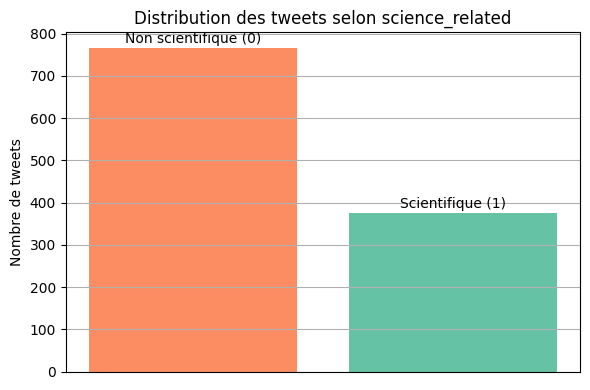

In [34]:
# Charger les données
df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Compter les valeurs de science_related
counts = df['science_related'].value_counts().sort_index()

# Affichage texte simple
print("Nombre de tweets non scientifiques (0) :", counts.get(0, 0))
print("Nombre de tweets scientifiques (1)     :", counts.get(1, 0))

# Labels
labels = ['Non scientifique (0)', 'Scientifique (1)']

# Graphique
plt.figure(figsize=(6, 4))
bars = plt.bar([0, 1], counts.values, color=['#fc8d62', '#66c2a5'])

# Ajouter uniquement les labels au-dessus des barres
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, labels[i],
             ha='center', va='bottom', fontsize=10)

# Mise en forme
plt.title("Distribution des tweets selon science_related")
plt.xticks([])  # Supprimer les ticks en bas
plt.ylabel("Nombre de tweets")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**3.1 Choix du meilleur équilibrage**

Pour trouver le meilleur équilibrage, on utilisera le même code que dans la section 3.2, la différence sera seulement dans la méthode où on comparera UnderSampling, OverSamping.

Ce qui change sera juste dans le pipeline :

- *("undersampler", RandomUnderSampler(random_state=42))*

- *("oversampler", RandomOverSampler(random_state=42))*


**3.2 Mise en pratique de notre méthode définie dans la partie 2**

On fait boucler notre pipeline en fonction des paramètres.

Quels paramètres manipuler ?

On va boucler sur les 5 modèles, les 2 types de vectorisations et prendre un prétraitement à la fois, ce qui nous donne 5 x 2 x 8 = 80 tests de modèles.

Ensuite avec nos résultats bruts, on regarde qu'est-ce qui donne les meilleurs cross validations.

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def MyCleanText(text, lowercase=True, removestopwords=True,
                getstemmer=True, getlemmatisation=True, stop_words=None,
                removeurls=True, removementions=True, removehashtags=True, removeemojis=True):
    if removeurls:
        text = re.sub(r"http\S+|www\S+", "", text)
    if removementions:
        text = re.sub(r"@\w+", "", text)
    if removehashtags:
        text = re.sub(r"#\w+", "", text)
    if removeemojis:
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)
    if lowercase:
        text = text.lower()
    text = re.sub(r"\d+", "", text)
    tokens = word_tokenize(text)
    if removestopwords and stop_words is not None:
        tokens = [t for t in tokens if t not in stop_words]
    if getlemmatisation:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    if getstemmer:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 lowercase=True,
                 removestopwords=True,
                 getstemmer=True,
                 getlemmatisation=True,
                 stop_words=None,
                 removeurls=True,
                 removementions=True,
                 removehashtags=True,
                 removeemojis=True):
        self.lowercase = lowercase
        self.removestopwords = removestopwords
        self.getstemmer = getstemmer
        self.getlemmatisation = getlemmatisation
        self.stop_words = stop_words if stop_words else set(stopwords.words('english'))
        self.removeurls = removeurls
        self.removementions = removementions
        self.removehashtags = removehashtags
        self.removeemojis = removeemojis

    def fit(self, X, y=None):
        return self

    def transform(self, X, **transform_params):
        return [MyCleanText(text,
                            lowercase=self.lowercase,
                            removestopwords=self.removestopwords,
                            getstemmer=self.getstemmer,
                            getlemmatisation=self.getlemmatisation,
                            stop_words=self.stop_words,
                            removeurls=self.removeurls,
                            removementions=self.removementions,
                            removehashtags=self.removehashtags,
                            removeemojis=self.removeemojis) for text in X]

def plot_confusion_matrix(cm, classes, title='Matrice de confusion', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Réel')
    plt.xlabel('Prédit')
    plt.title(title)
    plt.tight_layout()
    plt.show()

df = pd.read_csv('scitweets_export.tsv', sep='\t')
X = df['text']
y = df['science_related']

models = {
    "SVM": SVC(kernel='linear'),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=30),
    "KNN": KNeighborsClassifier()
}

seed = 30
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score)}

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results = {}

preprocessing_options = [
    'lowercase',
    'removeurls',
    'removementions',
    'removehashtags',
    'removeemojis',
    'removestopwords',
    'getstemmer',
    'getlemmatisation'
]

for name, model in models.items():
    for vectorizer_name, vectorizer in [
        ("TF-IDF", TfidfVectorizer(lowercase=False)),
        ("Bag of Words", CountVectorizer(lowercase=False))
    ]:
        for active_param in preprocessing_options:
            param_set = {option: False for option in preprocessing_options}
            param_set[active_param] = True
            print(f"Test: {name} avec {vectorizer_name}, {active_param}=True (RandomOverSampler)")
            cleaner = TextNormalizer(
                lowercase=param_set['lowercase'],
                removeurls=param_set['removeurls'],
                removementions=param_set['removementions'],
                removehashtags=param_set['removehashtags'],
                removeemojis=param_set['removeemojis'],
                removestopwords=param_set['removestopwords'],
                getstemmer=param_set['getstemmer'],
                getlemmatisation=param_set['getlemmatisation']
            )
            pipe = ImbPipeline([
                ("cleaner", cleaner),
                ("vectorizer", vectorizer),
                ("oversampler", RandomOverSampler(random_state=seed)),
                ("classifier", model)
            ])
            try:
                scores = cross_validate(pipe, X, y, cv=k_fold, scoring=scoring, n_jobs=1, error_score='raise')
                accuracy_mean = scores['test_accuracy'].mean()
                accuracy_std = scores['test_accuracy'].std()
                f1_mean = scores['test_f1'].mean()
                f1_std = scores['test_f1'].std()
                key = f"{name}_{vectorizer_name}_{active_param}=True_RandomOverSampler"
                results[key] = {
                    'accuracy': accuracy_mean,
                    'accuracy_std': accuracy_std,
                    'f1': f1_mean,
                    'f1_std': f1_std
                }
                print(f"Accuracy moyenne ± écart type: {accuracy_mean:.3f} ± {accuracy_std:.3f}")
                print(f"F1-score moyen ± écart type: {f1_mean:.3f} ± {f1_std:.3f}")
            except Exception as e:
                print(f"Erreur validation croisée ({key}) : {e}")

best_models_accuracy = sorted(results.items(), key=lambda item: item[1]['accuracy'], reverse=True)[:10]
best_models_f1 = sorted(results.items(), key=lambda item: item[1]['f1'], reverse=True)[:10]

print("\nTop 10 des modèles par Accuracy (RandomOverSampler):")
for model, scores in best_models_accuracy:
    print(f"{model}: Accuracy = {scores['accuracy']:.3f} ± {scores['accuracy_std']:.3f}, F1-score = {scores['f1']:.3f} ± {scores['f1_std']:.3f}")

print("\nTop 10 des modèles par F1-score (RandomOverSampler):")
for model, scores in best_models_f1:
    print(f"{model}: Accuracy = {scores['accuracy']:.3f} ± {scores['accuracy_std']:.3f}, F1-score = {scores['f1']:.3f} ± {scores['f1_std']:.3f}")

results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['Model', 'Accuracy', 'Accuracy_std', 'F1-score', 'F1-score_std']
results_df.to_csv('model_results_with_std.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Test: SVM avec TF-IDF, lowercase=True (RandomOverSampler)
Accuracy moyenne ± écart type: 0.812 ± 0.034
F1-score moyen ± écart type: 0.710 ± 0.053
Test: SVM avec TF-IDF, removeurls=True (RandomOverSampler)
Accuracy moyenne ± écart type: 0.800 ± 0.043
F1-score moyen ± écart type: 0.673 ± 0.076
Test: SVM avec TF-IDF, removementions=True (RandomOverSampler)
Accuracy moyenne ± écart type: 0.805 ± 0.055
F1-score moyen ± écart type: 0.701 ± 0.086
Test: SVM avec TF-IDF, removehashtags=True (RandomOverSampler)
Accuracy moyenne ± écart type: 0.807 ± 0.048
F1-score moyen ± écart type: 0.703 ± 0.074
Test: SVM avec TF-IDF, removeemojis=True (RandomOverSampler)
Accuracy moyenne ± écart type: 0.806 ± 0.055
F1-score moyen ± écart type: 0.702 ± 0.086
Test: SVM avec TF-IDF, removestopwords=True (RandomOverSampler)
Accuracy moyenne ± écart type: 0.811 ± 0.044
F1-score moyen ± écart type: 0.706 ± 0.077
Test: SVM avec TF-IDF, getstemmer=True (RandomOverSampler)
Accuracy moyenne ± écart type: 0.810 ± 0.031


**3.3 Affinage des tests**

On adapte ainsi notre pipeline selon les résultats analysés précédemment donc modification de notre Transformer et on enlève ce qu'on ne veut plus analyser (KNN, remove_urls, ...)

On va faire une analyse 2 à 2 des prétraitements Lowercase, Stemming, Lowercase x Stemming (both dans le code)

Introduisons les écarts types pour mieux évaluer les résultats

In [4]:


def MyCleanText(text, lowercase=True, getstemmer=True):
    if lowercase:
        text = text.lower()
    text = re.sub(r"\d+", "", text)
    tokens = word_tokenize(text)
    if getstemmer:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(t) for t in tokens if t]
    return " ".join(tokens)

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, lowercase=True, getstemmer=True):
        self.lowercase = lowercase
        self.getstemmer = getstemmer

    def fit(self, X, y=None):
        return self

    def transform(self, X, **transform_params):
        return [MyCleanText(text,
                           lowercase=self.lowercase,
                           getstemmer=self.getstemmer) for text in X]

def plot_confusion_matrix(cm, classes, title='Matrice de confusion', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Réel')
    plt.xlabel('Prédit')
    plt.title(title)
    plt.tight_layout()
    plt.show()

df = pd.read_csv('scitweets_export.tsv', sep='\t')
X = df['text']
y = df['science_related']

models = {                               # <---- ICI NOS 2 MEILLEURS MODELES
    "SVM": SVC(kernel='linear'),
    "Logistic Regression": LogisticRegression(max_iter=1000),
}

seed = 30
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score)}

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results = {}

preprocessing_options = [              #<------ ICI NOS 2 MEILLEURS PRETRAITEMENTS
    'lowercase',
    'getstemmer',
    'both'
]

for name, model in models.items():
    for vectorizer_name, vectorizer in [
        ("TF-IDF", TfidfVectorizer(lowercase=False)),      #<---- On garde que tf idf
    ]:
        for option in preprocessing_options:
            param_set = {'lowercase': False, 'getstemmer': False}

            if option == 'lowercase':
                param_set['lowercase'] = True
                test_name = f"{name}_{vectorizer_name}_lowercase_RandomOverSampler"
            elif option == 'getstemmer':
                param_set['getstemmer'] = True
                test_name = f"{name}_{vectorizer_name}_getstemmer_RandomOverSampler"
            elif option == 'both':
                param_set['lowercase'] = True
                param_set['getstemmer'] = True
                test_name = f"{name}_{vectorizer_name}_lowercase_getstemmer_RandomOverSampler"

            print(f"Test: {name} avec {vectorizer_name}, {test_name}")

            cleaner = TextNormalizer(
                lowercase=param_set['lowercase'],
                getstemmer=param_set['getstemmer']
            )

            pipe = ImbPipeline([
                ("cleaner", cleaner),
                ("vectorizer", vectorizer),
                ("oversampler", RandomOverSampler(random_state=seed)),
                ("classifier", model)
            ])
            try:
                scores = cross_validate(pipe, X, y, cv=k_fold, scoring=scoring, n_jobs=1, error_score='raise')
                accuracy_mean = scores['test_accuracy'].mean()
                accuracy_std = scores['test_accuracy'].std()
                f1_mean = scores['test_f1'].mean()

                results[test_name] = {'accuracy': accuracy_mean, 'accuracy_std': accuracy_std, 'f1': f1_mean}
                print(f"Accuracy moyenne (RandomOverSampler) : {accuracy_mean:.3f} ± {accuracy_std:.3f}, F1-score moyen (RandomOverSampler) : {f1_mean:.3f}")
            except Exception as e:
                print(f"Erreur validation croisée ({test_name}) : {e}")

best_models_accuracy = sorted(results.items(), key=lambda item: item[1]['accuracy'], reverse=True)[:10]
best_models_f1 = sorted(results.items(), key=lambda item: item[1]['f1'], reverse=True)[:10]

print("\nTop 10 des modèles par Accuracy (RandomOverSampler):")
for model, scores in best_models_accuracy:
    print(f"{model}: Accuracy = {scores['accuracy']:.3f} ± {scores['accuracy_std']:.3f}, F1-score = {scores['f1']:.3f}")

print("\nTop 10 des modèles par F1-score (RandomOverSampler):")
for model, scores in best_models_f1:
    print(f"{model}: Accuracy = {scores['accuracy']:.3f} ± {scores['accuracy_std']:.3f}, F1-score = {scores['f1']:.3f}")

results_df = pd.DataFrame([{'model': model, 'accuracy': scores['accuracy'], 'accuracy_std': scores['accuracy_std'], 'f1': scores['f1']}
                          for model, scores in results.items()])
results_df.to_csv('model_results_stemming_lowercase.csv', index=False)

Test: SVM avec TF-IDF, SVM_TF-IDF_lowercase_RandomOverSampler
Accuracy moyenne (RandomOverSampler) : 0.812 ± 0.034, F1-score moyen (RandomOverSampler) : 0.710
Test: SVM avec TF-IDF, SVM_TF-IDF_getstemmer_RandomOverSampler
Accuracy moyenne (RandomOverSampler) : 0.810 ± 0.031, F1-score moyen (RandomOverSampler) : 0.709
Test: SVM avec TF-IDF, SVM_TF-IDF_lowercase_getstemmer_RandomOverSampler
Accuracy moyenne (RandomOverSampler) : 0.810 ± 0.031, F1-score moyen (RandomOverSampler) : 0.709
Test: Logistic Regression avec TF-IDF, Logistic Regression_TF-IDF_lowercase_RandomOverSampler
Accuracy moyenne (RandomOverSampler) : 0.806 ± 0.034, F1-score moyen (RandomOverSampler) : 0.725
Test: Logistic Regression avec TF-IDF, Logistic Regression_TF-IDF_getstemmer_RandomOverSampler
Accuracy moyenne (RandomOverSampler) : 0.811 ± 0.039, F1-score moyen (RandomOverSampler) : 0.728
Test: Logistic Regression avec TF-IDF, Logistic Regression_TF-IDF_lowercase_getstemmer_RandomOverSampler
Accuracy moyenne (Rando

**3.5 Recherche des hyperparamètres**

Maintenant qu'on a trouvé un bon classifieur :

- Modèle : Régression Logistic
- Prétraitement : stemmatization
- Vectorisation : TF-IDF

Nous pouvons rechercher les meilleurs hyperparamètres sur ce modèle.

In [48]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')

# Fonction de nettoyage pour les tweets (uniquement stemmatisation)
def MyCleanText(text, lowercase=True, removestopwords=True, getstemmer=True, stop_words=None):
    if lowercase:
        text = text.lower()
    text = re.sub(r"\d+", "", text)
    tokens = word_tokenize(text)
    if removestopwords and stop_words is not None:
        tokens = [t for t in tokens if t not in stop_words]
    if getstemmer:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

# Classe de nettoyage compatible pipeline (uniquement stemmatisation)
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, lowercase=True, removestopwords=True, getstemmer=True, stop_words=None):
        self.lowercase = lowercase
        self.removestopwords = removestopwords
        self.getstemmer = getstemmer
        self.stop_words = stop_words if stop_words else set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X, **transform_params):
        return [MyCleanText(text,
                            lowercase=self.lowercase,
                            removestopwords=self.removestopwords,
                            getstemmer=self.getstemmer,
                            stop_words=self.stop_words) for text in X]

# Chargement des données
df = pd.read_csv('scitweets_export.tsv', sep='\t')
X = df['text']
y = df['science_related']

# Séparation des données
seed = 30
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Configuration de la validation croisée
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score)}

# Pipeline avec nettoyage (Stemming activé), TF-IDF, RandomOverSampler et LogisticRegression
pipe = ImbPipeline([
    ("cleaner", TextNormalizer(lowercase=True, removestopwords=True, getstemmer=True)),
    ("vectorizer", TfidfVectorizer(lowercase=False)),
    ("oversampler", RandomOverSampler(random_state=seed)),
    ("classifier", LogisticRegression(max_iter=1000, random_state=seed))
])

# Paramètres pour RandomSearchCV
param_dist = {
    'vectorizer__max_features': randint(500, 5000),
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': uniform(0.1, 10),
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__penalty': ['l2']
}

# RandomSearchCV
random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20,
    cv=k_fold,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True,
    n_jobs=1,
    random_state=seed
)

# Exécution de RandomSearchCV
print("Exécution de RandomSearchCV...")
random_search.fit(X_train_raw, y_train)

# Résultats RandomSearchCV
print("\nMeilleurs paramètres (RandomSearchCV):")
print(random_search.best_params_)
print(f"Meilleure Accuracy (moyenne): {random_search.best_score_:.3f}")

# Validation croisée pour les meilleurs paramètres
best_pipe_random = random_search.best_estimator_
scores_random = cross_validate(best_pipe_random, X, y, cv=k_fold, scoring=scoring, n_jobs=1)
accuracy_mean_random = scores_random['test_accuracy'].mean()
accuracy_std_random = scores_random['test_accuracy'].std()
f1_mean_random = scores_random['test_f1'].mean()
f1_std_random = scores_random['test_f1'].std()

print("\nRésultats RandomSearchCV (k-fold):")
print(f"Accuracy: {accuracy_mean_random:.3f} ± {accuracy_std_random:.3f}")
print(f"F1-score: {f1_mean_random:.3f} ± {f1_std_random:.3f}")

# Paramètres pour GridSearchCV (basé sur RandomSearchCV)
param_grid = {
    'vectorizer__max_features': [max(500, random_search.best_params_['vectorizer__max_features'] - 500),
                                 random_search.best_params_['vectorizer__max_features'],
                                 random_search.best_params_['vectorizer__max_features'] + 500],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [random_search.best_params_['classifier__C'] / 2,
                      random_search.best_params_['classifier__C'],
                      random_search.best_params_['classifier__C'] * 2],
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__penalty': ['l2']
}

# GridSearchCV
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=k_fold,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True,
    n_jobs=1
)

# Exécution de GridSearchCV
print("\nExécution de GridSearchCV...")
grid_search.fit(X_train_raw, y_train)

# Résultats GridSearchCV
print("\nMeilleurs paramètres (GridSearchCV):")
print(grid_search.best_params_)
print(f"Meilleure Accuracy (moyenne): {grid_search.best_score_:.3f}")

# Validation croisée pour les meilleurs paramètres
best_pipe_grid = grid_search.best_estimator_
scores_grid = cross_validate(best_pipe_grid, X, y, cv=k_fold, scoring=scoring, n_jobs=1)
accuracy_mean_grid = scores_grid['test_accuracy'].mean()
accuracy_std_grid = scores_grid['test_accuracy'].std()
f1_mean_grid = scores_grid['test_f1'].mean()
f1_std_grid = scores_grid['test_f1'].std()

print("\nRésultats GridSearchCV (k-fold):")
print(f"Accuracy: {accuracy_mean_grid:.3f} ± {accuracy_std_grid:.3f}")
print(f"F1-score: {f1_mean_grid:.3f} ± {f1_std_grid:.3f}")

# Sauvegarde des résultats en CSV
results = {
    'Method': ['RandomSearchCV', 'GridSearchCV'],
    'Accuracy_Mean': [accuracy_mean_random, accuracy_mean_grid],
    'Accuracy_Std': [accuracy_std_random, accuracy_std_grid],
    'F1_Mean': [f1_mean_random, f1_mean_grid],
    'F1_Std': [f1_std_random, f1_std_grid]
}
results_df = pd.DataFrame(results)
results_df.to_csv('./Etape1_Tache1/hyperparameter_tuning_results.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Exécution de RandomSearchCV...

Meilleurs paramètres (RandomSearchCV):
{'classifier__C': np.float64(7.07950164982001), 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'vectorizer__max_features': 1968, 'vectorizer__ngram_range': (1, 1)}
Meilleure Accuracy (moyenne): 0.802

Résultats RandomSearchCV (k-fold):
Accuracy: 0.817 ± 0.026
F1-score: 0.721 ± 0.058

Exécution de GridSearchCV...

Meilleurs paramètres (GridSearchCV):
{'classifier__C': np.float64(3.539750824910005), 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'vectorizer__max_features': 1968, 'vectorizer__ngram_range': (1, 1)}
Meilleure Accuracy (moyenne): 0.808

Résultats GridSearchCV (k-fold):
Accuracy: 0.816 ± 0.025
F1-score: 0.724 ± 0.046


Désormais, testons RandomSearch avec de nouveaux paramètres (augmentation du nombre de features à prendre en compte et comparaison avec 50, 100 et 150 itérations)

In [50]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')

# Fonction de nettoyage pour les tweets (uniquement stemmatisation)
def MyCleanText(text, lowercase=True, removestopwords=True, getstemmer=True, stop_words=None):
    if lowercase:
        text = text.lower()
    text = re.sub(r"\d+", "", text)
    tokens = word_tokenize(text)
    if removestopwords and stop_words is not None:
        tokens = [t for t in tokens if t not in stop_words]
    if getstemmer:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

# Classe de nettoyage compatible pipeline (uniquement stemmatisation)
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, lowercase=True, removestopwords=True, getstemmer=True, stop_words=None):
        self.lowercase = lowercase
        self.removestopwords = removestopwords
        self.getstemmer = getstemmer
        self.stop_words = stop_words if stop_words else set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X, **transform_params):
        return [MyCleanText(text,
                            lowercase=self.lowercase,
                            removestopwords=self.removestopwords,
                            getstemmer=self.getstemmer,
                            stop_words=self.stop_words) for text in X]

# Chargement des données
df = pd.read_csv('scitweets_export.tsv', sep='\t')
X = df['text']
y = df['science_related']

# Séparation des données
seed = 30
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Configuration de la validation croisée
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score)}

# Pipeline avec nettoyage (Stemming activé), TF-IDF, RandomOverSampler et LogisticRegression
pipe = ImbPipeline([
    ("cleaner", TextNormalizer(lowercase=True, removestopwords=True, getstemmer=True)),
    ("vectorizer", TfidfVectorizer(lowercase=False)),
    ("oversampler", RandomOverSampler(random_state=seed)),
    ("classifier", LogisticRegression(max_iter=1000, random_state=seed))
])

# Paramètres pour RandomSearchCV
param_dist = {
    'vectorizer__max_features': randint(1000, 10000),
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
    'vectorizer__max_df': uniform(0.5, 1.0),
    'vectorizer__use_idf': [True, False],
    'vectorizer__norm': ['l1', 'l2', None],
    'classifier__C': uniform(0.01, 20),
    'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
    'classifier__penalty': ['l2', 'l1']
}

n_iters_to_test = [25, 35, 50]
all_results = []

for n_iter in n_iters_to_test:
    print(f"\n--- Exécution de RandomSearchCV avec n_iter = {n_iter} ---")
    # RandomSearchCV
    random_search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=k_fold,
        scoring=scoring,
        refit='accuracy',
        return_train_score=True,
        n_jobs=1,
        random_state=seed
    )

    # Exécution de RandomSearchCV
    print("Exécution de RandomSearchCV...")
    random_search.fit(X_train_raw, y_train)

    # Résultats RandomSearchCV
    print("\nMeilleurs paramètres (RandomSearchCV):")
    print(random_search.best_params_)
    print(f"Meilleure Accuracy (moyenne): {random_search.best_score_:.3f}")

    # Validation croisée pour les meilleurs paramètres
    best_pipe_random = random_search.best_estimator_
    scores_random = cross_validate(best_pipe_random, X, y, cv=k_fold, scoring=scoring, n_jobs=1)
    accuracy_mean_random = scores_random['test_accuracy'].mean()
    accuracy_std_random = scores_random['test_accuracy'].std()
    f1_mean_random = scores_random['test_f1'].mean()
    f1_std_random = scores_random['test_f1'].std()

    print("\nRésultats RandomSearchCV (k-fold):")
    print(f"Accuracy: {accuracy_mean_random:.3f} ± {accuracy_std_random:.3f}")
    print(f"F1-score: {f1_mean_random:.3f} ± {f1_std_random:.3f}")

    all_results.append({
        'n_iter': n_iter,
        'Accuracy_Mean': accuracy_mean_random,
        'Accuracy_Std': accuracy_std_random,
        'F1_Mean': f1_mean_random,
        'F1_Std': f1_std_random,
        'Best_Params': random_search.best_params_
    })

# Sauvegarde des résultats en CSV
results_df = pd.DataFrame(all_results)
results_df.to_csv('./Etape1_Tache1/random_search_results_multiple_n_iter.csv', index=False)

print("\nRésultats pour différentes valeurs de n_iter sauvegardés dans random_search_results_multiple_n_iter.csv")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



--- Exécution de RandomSearchCV avec n_iter = 25 ---
Exécution de RandomSearchCV...

Meilleurs paramètres (RandomSearchCV):
{'classifier__C': np.float64(3.621797647655179), 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'vectorizer__max_df': np.float64(0.5559750189999217), 'vectorizer__max_features': 1455, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l1', 'vectorizer__use_idf': True}
Meilleure Accuracy (moyenne): 0.787

Résultats RandomSearchCV (k-fold):
Accuracy: 0.796 ± 0.051
F1-score: 0.713 ± 0.074

--- Exécution de RandomSearchCV avec n_iter = 35 ---
Exécution de RandomSearchCV...

Meilleurs paramètres (RandomSearchCV):
{'classifier__C': np.float64(3.621797647655179), 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'vectorizer__max_df': np.float64(0.5559750189999217), 'vectorizer__max_features': 1455, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l1', 'vectorizer__use_idf': True}
Meille

**3.6 Recherche de features et présentation des résultats finaux**

On recherche les features les plus répandus dans les 2 catégories et on entraîne notre modèle dessus.

Entraînement du modèle avec features spécifiques aux classes...

--- Rapport de Classification avec Features Améliorées ---
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       158
           1       0.65      0.73      0.69        70

    accuracy                           0.80       228
   macro avg       0.76      0.78      0.77       228
weighted avg       0.81      0.80      0.80       228



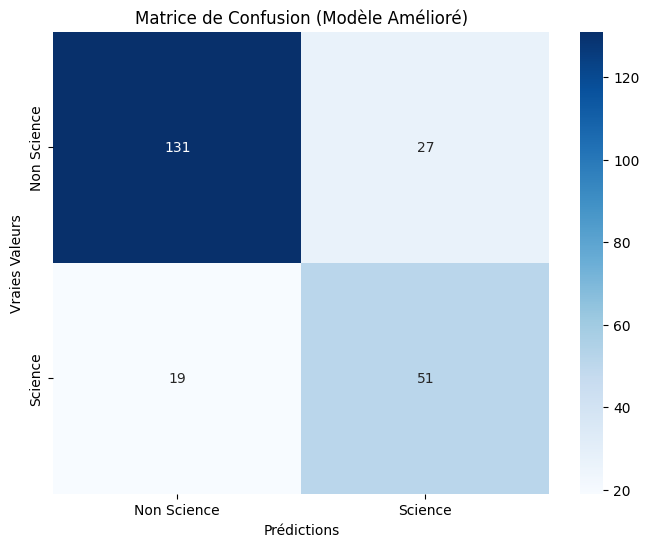


Entraînement du modèle original pour comparaison...

--- Rapport de Classification (Modèle Original) ---
              precision    recall  f1-score   support

           0       0.88      0.80      0.83       158
           1       0.62      0.74      0.68        70

    accuracy                           0.78       228
   macro avg       0.75      0.77      0.75       228
weighted avg       0.80      0.78      0.79       228


--- Comparaison des Modèles (Validation Croisée) ---
Accuracy - Modèle Original: 0.8167 +- 0.0284
Accuracy - Modèle Amélioré: 0.8237 +- 0.0230
Différence d'accuracy: 0.70%
F1-Score - Modèle Original: 0.7334 +- 0.0479
F1-Score - Modèle Amélioré: 0.7459 +- 0.0294
Différence de F1-Score: 1.26%


In [109]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold, train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Fonction de nettoyage pour les tweets
def MyCleanText(text, lowercase=True, removestopwords=True, getstemmer=True, stop_words=None):
    if lowercase:
        text = text.lower()
    text = re.sub(r"\d+", "", text)
    tokens = word_tokenize(text)
    if removestopwords and stop_words is not None:
        tokens = [t for t in tokens if t not in stop_words]
    if getstemmer:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

# Classe de nettoyage compatible pipeline
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, lowercase=True, removestopwords=True, getstemmer=True, stop_words=None):
        self.lowercase = lowercase
        self.removestopwords = removestopwords
        self.getstemmer = getstemmer
        self.stop_words = stop_words if stop_words else set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X, **transform_params):
        return [MyCleanText(text,
                                     lowercase=self.lowercase,
                                     removestopwords=self.removestopwords,
                                     getstemmer=self.getstemmer,
                                     stop_words=self.stop_words) for text in X]

# Transformateur pour les mots spécifiques aux classes
class ClassSpecificFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Mots distinctifs pour classe 0 (Non Science)
        self.non_science_words = [
            "http://t.co", "https://t.co", "lol", "omg", "🤣", "‼️", "😂", "💔", "💕"
        ]

        # Mots distinctifs pour classe 1 (Science)
        self.science_words = [
            ".", ","
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = np.zeros((len(X), len(self.non_science_words) + len(self.science_words)))

        for i, text in enumerate(X):
            # Compter les occurrences des mots spécifiques
            for j, word in enumerate(self.non_science_words):
                features[i, j] = text.count(word)

            for j, word in enumerate(self.science_words):
                features[i, j + len(self.non_science_words)] = text.count(word)

        return features

# Combinaison de TF-IDF et des features spécifiques à la classe
class CombinedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, tfidf_params):
        self.tfidf_params = tfidf_params
        self.tfidf = TfidfVectorizer(**tfidf_params)
        self.class_features = ClassSpecificFeatures()

    def fit(self, X, y=None):
        self.tfidf.fit(X)
        self.class_features.fit(X)
        return self

    def transform(self, X):
        tfidf_features = self.tfidf.transform(X)
        class_specific_features = self.class_features.transform(X)
        # Combiner les deux types de features
        return hstack([tfidf_features, class_specific_features])

# Chargement des données
df = pd.read_csv('scitweets_export.tsv', sep='\t')
X = df['text']
y = df['science_related']

# Séparation des données
seed = 30
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Configuration de la validation croisée
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Hyperparamètres TF-IDF
tfidf_params = {
    'lowercase': False,
    'max_df': 0.7494966678028915,
    'max_features': 1906,
    'min_df': 1,
    'ngram_range': (1, 3),
    'norm': 'l2',
    'use_idf': True
}

# Hyperparamètres du classifier
classifier_params = {
    'C': 0.9196313693076863,
    'penalty': 'l2',
    'solver': 'liblinear',
    'max_iter': 1000,
    'random_state': seed
}

# Création du pipeline amélioré
improved_pipeline = ImbPipeline([
    ("cleaner", TextNormalizer()),
    ("features", CombinedFeatures(tfidf_params)),
    ("oversampler", RandomOverSampler(random_state=seed)),
    ("classifier", LogisticRegression(**classifier_params))
])

# Entraînement du modèle amélioré
print("Entraînement du modèle avec features spécifiques aux classes...")
improved_pipeline.fit(X_train_raw, y_train)

# Prédictions sur l'ensemble de test
y_pred = improved_pipeline.predict(X_test_raw)

# Rapport de classification
print("\n--- Rapport de Classification avec Features Améliorées ---")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Science', 'Science'], yticklabels=['Non Science', 'Science'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies Valeurs')
plt.title('Matrice de Confusion (Modèle Amélioré)')
plt.show()

# Pour comparer, créons également le modèle original
original_pipeline = ImbPipeline([
    ("cleaner", TextNormalizer()),
    ("vectorizer", TfidfVectorizer(**tfidf_params)),
    ("oversampler", RandomOverSampler(random_state=seed)),
    ("classifier", LogisticRegression(**classifier_params))
])

# Entraînement du modèle original
print("\nEntraînement du modèle original pour comparaison...")
original_pipeline.fit(X_train_raw, y_train)
y_pred_original = original_pipeline.predict(X_test_raw)

# Rapport de classification pour le modèle original
print("\n--- Rapport de Classification (Modèle Original) ---")
print(classification_report(y_test, y_pred_original))

# Validation croisée sur les deux modèles
scoring = {'accuracy': 'accuracy', 'f1': 'f1'}

# Modèle amélioré
scores_improved = cross_validate(improved_pipeline, X, y, cv=k_fold, scoring=scoring)
improved_accuracy_mean = scores_improved['test_accuracy'].mean()
improved_accuracy_std = scores_improved['test_accuracy'].std()
improved_f1_mean = scores_improved['test_f1'].mean()
improved_f1_std = scores_improved['test_f1'].std()

# Modèle original
scores_original = cross_validate(original_pipeline, X, y, cv=k_fold, scoring=scoring)
original_accuracy_mean = scores_original['test_accuracy'].mean()
original_accuracy_std = scores_original['test_accuracy'].std()
original_f1_mean = scores_original['test_f1'].mean()
original_f1_std = scores_original['test_f1'].std()

# Comparaison des performances
print("\n--- Comparaison des Modèles (Validation Croisée) ---")
print(f"Accuracy - Modèle Original: {original_accuracy_mean:.4f} +- {original_accuracy_std:.4f}")
print(f"Accuracy - Modèle Amélioré: {improved_accuracy_mean:.4f} +- {improved_accuracy_std:.4f}")
print(f"Différence d'accuracy: {(improved_accuracy_mean - original_accuracy_mean) * 100:.2f}%")
print(f"F1-Score - Modèle Original: {original_f1_mean:.4f} +- {original_f1_std:.4f}")
print(f"F1-Score - Modèle Amélioré: {improved_f1_mean:.4f} +- {improved_f1_std:.4f}")
print(f"Différence de F1-Score: {(improved_f1_mean - original_f1_mean) * 100:.2f}%")

# **4. Deuxième tâche de classification : Claim/Ref vs Context**

Nous allons travailler sur une classification binaire multi-classe

**4.1 Visualisation des déséquilibres de classes**




Distribution initiale :
science_core
1    342
0     33
Name: count, dtype: int64


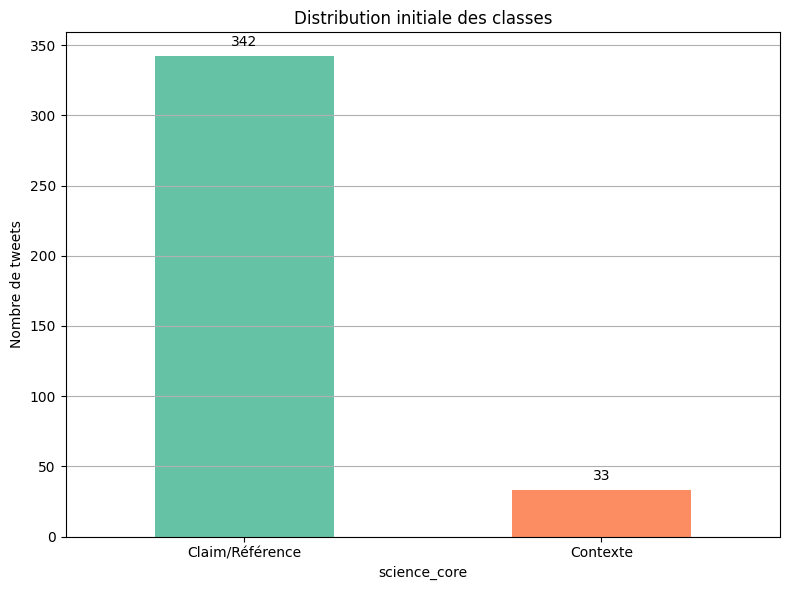

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Garder seulement les tweets "science_related"
df = df[df['science_related'] == 1].copy()

# Créer un label binaire : 1 si claim ou référence, 0 sinon (contexte)
df['science_core'] = ((df['scientific_claim'] == 1) | (df['scientific_reference'] == 1)).astype(int)

# Affichage initial
original_counts = df['science_core'].value_counts()
print("Distribution initiale :")
print(original_counts)

plt.figure(figsize=(8, 6))
bars = original_counts.plot(kind='bar', color=['#66c2a5', '#fc8d62'])
plt.title("Distribution initiale des classes")
plt.xticks([0, 1], ['Claim/Référence', 'Contexte'], rotation=0)
plt.ylabel("Nombre de tweets")
plt.grid(axis='y')

# Ajouter les nombres sur les barres
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

**4.2 Recherche de résultats pertinents**

Dans ce cas, nous allons reprendre la méthodologie de la première partie

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Télécharger les ressources nécessaires pour NLTK (à exécuter une seule fois)
# Change the exception handling to LookupError
try:
    nltk.data.find('corpora/wordnet')
except LookupError: # Handle LookupError here
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError: # Handle LookupError here as well
    nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# Charger les données
df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Garder seulement les tweets "science_related"
df = df[df['science_related'] == 1].copy()

# Créer un label binaire : 1 si claim ou référence, 0 sinon (contexte)
df['science_core'] = ((df['scientific_claim'] == 1) | (df['scientific_reference'] == 1)).astype(int)

# Séparer les caractéristiques (X) et la variable cible (y)
X = df['text'].apply(preprocess_text)
y = df['science_core']

# Division des données en train et test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Vectorisation TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Équilibrage des données d'entraînement avec RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled_tfidf, y_train_resampled = ros.fit_resample(X_train_tfidf, y_train)

# Modèles à tester (sans GridSearchCV pour l'instant)
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

print("Résultats sur les données déséquilibrées :")
for name, model in models.items():
    model.fit(X_train_tfidf.toarray(), y_train)
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test_tfidf.toarray())
    print(classification_report(y_test, y_pred))
    #cm = confusion_matrix(y_test, y_pred)
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    #            xticklabels=['Contexte', 'Claim/Réf'], yticklabels=['Contexte', 'Claim/Réf'])
    #plt.title(f'Matrice de Confusion - {name} (Déséquilibré)')
    #plt.show()

print("\n\nRésultats sur les données équilibrées (avec RandomOverSampler) :")
for name, model in models.items():
    model.fit(X_train_resampled_tfidf.toarray(), y_train_resampled)
    print(f"\n--- {name} (Équilibré) ---")
    y_pred = model.predict(X_test_tfidf.toarray())
    print(classification_report(y_test, y_pred))
    #cm = confusion_matrix(y_test, y_pred)
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
    #            xticklabels=['Contexte', 'Claim/Réf'], yticklabels=['Contexte', 'Claim/Réf'])
    #plt.title(f'Matrice de Confusion - {name} (Équilibré)')
    #plt.show()

# --- Test avec Lemmatisation ---
X_train_lemmatized = X_train.apply(lemmatize_text)
X_test_lemmatized = X_test.apply(lemmatize_text)

tfidf_vectorizer_lemma = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf_lemma = tfidf_vectorizer_lemma.fit_transform(X_train_lemmatized)
X_test_tfidf_lemma = tfidf_vectorizer_lemma.transform(X_test_lemmatized)

X_train_resampled_tfidf_lemma, y_train_resampled_lemma = ros.fit_resample(X_train_tfidf_lemma, y_train)

print("\n\nRésultats sur les données équilibrées (avec RandomOverSampler) et Lemmatisation :")
for name, model in models.items():
    model.fit(X_train_resampled_tfidf_lemma.toarray(), y_train_resampled_lemma)
    print(f"\n--- {name} (Équilibré, Lemmatisé) ---")
    y_pred_lemma = model.predict(X_test_tfidf_lemma.toarray())
    print(classification_report(y_test, y_pred_lemma))
    #cm_lemma = confusion_matrix(y_test, y_pred_lemma)
    #sns.heatmap(cm_lemma, annot=True, fmt='d', cmap='Oranges',
    #            xticklabels=['Contexte', 'Claim/Réf'], yticklabels=['Contexte', 'Claim/Réf'])
    #plt.title(f'Matrice de Confusion - {name} (Équilibré, Lemmatisé)')
    #plt.show()

# --- Test avec Stemmatisation ---
X_train_stemmed = X_train.apply(stem_text)
X_test_stemmed = X_test.apply(stem_text)

tfidf_vectorizer_stem = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf_stem = tfidf_vectorizer_stem.fit_transform(X_train_stemmed)
X_test_tfidf_stem = tfidf_vectorizer_stem.transform(X_test_stemmed)

X_train_resampled_tfidf_stem, y_train_resampled_stem = ros.fit_resample(X_train_tfidf_stem, y_train)

print("\n\nRésultats sur les données équilibrées et Stemmatisation :")
for name, model in models.items():
    model.fit(X_train_resampled_tfidf_stem.toarray(), y_train_resampled_stem)
    print(f"\n--- {name} (Équilibré, Stemmatisé) ---")
    y_pred_stem = model.predict(X_test_tfidf_stem.toarray())
    print(classification_report(y_test, y_pred_stem))
    #cm_stem = confusion_matrix(y_test, y_pred_stem)
    #sns.heatmap(cm_stem, annot=True, fmt='d', cmap='Reds',
    #            xticklabels=['Contexte', 'Claim/Réf'], yticklabels=['Contexte', 'Claim/Réf'])
    #plt.title(f'Matrice de Confusion - {name} (Équilibré, Stemmatisé)')
    #plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Résultats sur les données déséquilibrées :

--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      0.93      0.92       103

    accuracy                           0.85       113
   macro avg       0.45      0.47      0.46       113
weighted avg       0.83      0.85      0.84       113


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      1.00      0.95       103

    accuracy                           0.91       113
   macro avg       0.46      0.50      0.48       113
weighted avg       0.83      0.91      0.87       113



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Random Forest ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      1.00      0.95       103

    accuracy                           0.91       113
   macro avg       0.46      0.50      0.48       113
weighted avg       0.83      0.91      0.87       113



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- SVM ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      1.00      0.95       103

    accuracy                           0.91       113
   macro avg       0.46      0.50      0.48       113
weighted avg       0.83      0.91      0.87       113



Résultats sur les données équilibrées (avec RandomOverSampler) :


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Naive Bayes (Équilibré) ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      0.93      0.92       103

    accuracy                           0.85       113
   macro avg       0.45      0.47      0.46       113
weighted avg       0.83      0.85      0.84       113


--- Logistic Regression (Équilibré) ---
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.93      1.00      0.96       103

    accuracy                           0.93       113
   macro avg       0.96      0.60      0.65       113
weighted avg       0.93      0.93      0.91       113


--- Random Forest (Équilibré) ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      1.00      0.95       103

    accuracy                           0.91       113
   macro avg       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- SVM (Équilibré) ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      1.00      0.95       103

    accuracy                           0.91       113
   macro avg       0.46      0.50      0.48       113
weighted avg       0.83      0.91      0.87       113



Résultats sur les données équilibrées (avec RandomOverSampler) et Lemmatisation :

--- Naive Bayes (Équilibré, Lemmatisé) ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      0.95      0.93       103

    accuracy                           0.87       113
   macro avg       0.45      0.48      0.46       113
weighted avg       0.83      0.87      0.85       113


--- Logistic Regression (Équilibré, Lemmatisé) ---
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.94      1.00      0.97       103

  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- SVM (Équilibré, Lemmatisé) ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      1.00      0.95       103

    accuracy                           0.91       113
   macro avg       0.46      0.50      0.48       113
weighted avg       0.83      0.91      0.87       113



Résultats sur les données équilibrées et Stemmatisation :

--- Naive Bayes (Équilibré, Stemmatisé) ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      0.97      0.94       103

    accuracy                           0.88       113
   macro avg       0.45      0.49      0.47       113
weighted avg       0.83      0.88      0.86       113


--- Logistic Regression (Équilibré, Stemmatisé) ---
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.94      1.00      0.97       103

    accuracy            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- SVM (Équilibré, Stemmatisé) ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.91      1.00      0.95       103

    accuracy                           0.91       113
   macro avg       0.46      0.50      0.48       113
weighted avg       0.83      0.91      0.87       113



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**4.3 Courbe ROC et mesure de l'AUC de notre modèle**

Comme nous sommes dans un contexte déséquilibré, il est utile de visualiser la manière dont notre modèle équilibre vrais et faux positifs.

On a choisi *Régression Logistique, équilibré, stemmatisé*

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!




--- Courbe ROC et AUC pour Logistic Regression (Équilibré, Stemmatisé) ---


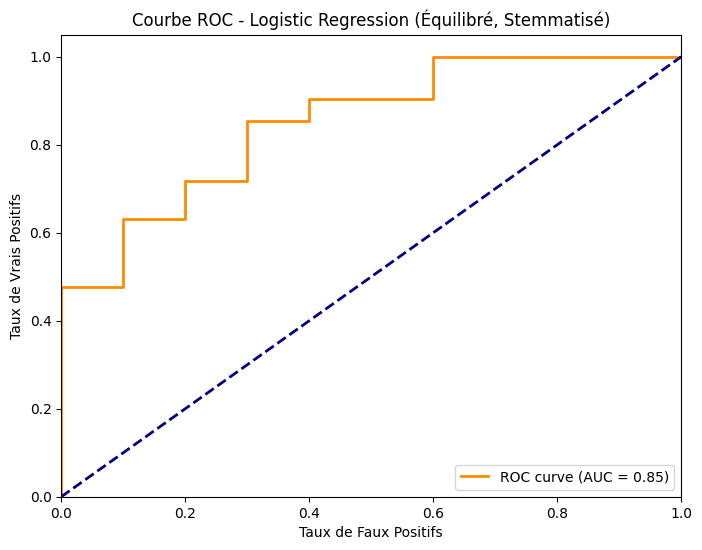


AUC pour Logistic Regression (Équilibré, Stemmatisé) : 0.85


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re

from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Télécharger les ressources nécessaires pour NLTK (à exécuter une seule fois)
# Change the exception handling to LookupError
try:
    nltk.data.find('corpora/wordnet')
except LookupError: # Handle LookupError here
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError: # Handle LookupError here as well
    nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def stem_text(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# Charger les données
df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Garder seulement les tweets "science_related"
df = df[df['science_related'] == 1].copy()

# Créer un label binaire : 1 si claim ou référence, 0 sinon (contexte)
df['science_core'] = ((df['scientific_claim'] == 1) | (df['scientific_reference'] == 1)).astype(int)

# Séparer les caractéristiques (X) et la variable cible (y)
X = df['text'].apply(preprocess_text)
y = df['science_core']

# Division des données en train et test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# --- Test avec Stemmatisation ---
X_train_stemmed = X_train.apply(stem_text)
X_test_stemmed = X_test.apply(stem_text)

tfidf_vectorizer_stem = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf_stem = tfidf_vectorizer_stem.fit_transform(X_train_stemmed)
X_test_tfidf_stem = tfidf_vectorizer_stem.transform(X_test_stemmed)

# Équilibrage des données d'entraînement avec RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled_tfidf_stem, y_train_resampled_stem = ros.fit_resample(X_train_tfidf_stem, y_train)

# ///////////////// UNIQUEMENT POUR LE MODELE Logistic Regression (Équilibré, Stemmatisé) trace la courbe ROC et Mesure l'AUC
print("\n\n--- Courbe ROC et AUC pour Logistic Regression (Équilibré, Stemmatisé) ---")
model_lr_stem = LogisticRegression(random_state=42)
model_lr_stem.fit(X_train_resampled_tfidf_stem.toarray(), y_train_resampled_stem)
y_pred_proba_lr_stem = model_lr_stem.predict_proba(X_test_tfidf_stem.toarray())[:, 1]

fpr_lr_stem, tpr_lr_stem, thresholds_lr_stem = roc_curve(y_test, y_pred_proba_lr_stem)
roc_auc_lr_stem = auc(fpr_lr_stem, tpr_lr_stem)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr_stem, tpr_lr_stem, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_lr_stem:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - Logistic Regression (Équilibré, Stemmatisé)')
plt.legend(loc="lower right")
plt.show()

print(f"\nAUC pour Logistic Regression (Équilibré, Stemmatisé) : {roc_auc_lr_stem:.2f}")

**4.4 Piste d'amélioration**

4.4.1 Recherche des meilleurs hyperparamètres


Essayons de rechercher les meilleurs hyperparamètres pour notre modèle.

In [34]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Définir l'espace des hyperparamètres à explorer
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': np.arange(100, 1000, 100),
    'l1_ratio': np.linspace(0, 1, 10)
}

# Filtrer les combinaisons valides d'hyperparamètres
param_distributions_corrected = [
    {'penalty': ['l1'], 'C': np.logspace(-4, 4, 20), 'solver': ['liblinear', 'saga'], 'max_iter': np.arange(100, 1000, 100)},
    {'penalty': ['l2'], 'C': np.logspace(-4, 4, 20), 'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], 'max_iter': np.arange(100, 1000, 100)},
    {'penalty': ['elasticnet'], 'C': np.logspace(-4, 4, 20), 'solver': ['saga'], 'max_iter': np.arange(100, 1000, 100), 'l1_ratio': np.linspace(0, 1, 10)},
    {'penalty': [None], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'max_iter': np.arange(100, 1000, 100)}
]

# Créer le modèle de régression logistique
model_lr = LogisticRegression(random_state=42)

# Configurer la recherche aléatoire des hyperparamètres
random_search = RandomizedSearchCV(
    model_lr,
    param_distributions_corrected, # Utiliser l'espace corrigé
    n_iter=10,  # Nombre d'itérations de recherche
    cv=5,       # Nombre de plis pour la validation croisée
    scoring='f1', # Métrique d'évaluation
    random_state=42,
    n_jobs=-1  # Utiliser tous les cœurs de processeur disponibles
)

# Lancer la recherche sur les données d'entraînement ré-échantillonnées
random_search.fit(X_train_resampled_tfidf_stem.toarray(), y_train_resampled_stem)

# Afficher les meilleurs hyperparamètres trouvés
print("\nMeilleurs hyperparamètres trouvés :", random_search.best_params_)

# Afficher le meilleur score F1 obtenu
print("Meilleur score F1 (validation croisée) :", random_search.best_score_)

# Évaluer le modèle avec les meilleurs hyperparamètres sur l'ensemble de test
best_model_lr_stem = random_search.best_estimator_
y_pred_best_lr_stem = best_model_lr_stem.predict(X_test_tfidf_stem.toarray())

print("\n--- Rapport de Classification pour Logistic Regression (Optimisé avec Random Search, Stemmatisé) ---")
print(classification_report(y_test, y_pred_best_lr_stem))


Meilleurs hyperparamètres trouvés : {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': np.int64(200), 'C': np.float64(4.281332398719396)}
Meilleur score F1 (validation croisée) : 1.0

--- Rapport de Classification pour Logistic Regression (Optimisé avec Random Search, Stemmatisé) ---
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.94      1.00      0.97       103

    accuracy                           0.95       113
   macro avg       0.97      0.70      0.77       113
weighted avg       0.95      0.95      0.94       113



Les résultats de la recherche d'hyperparamètres sont les même qu'initialement.

4.4.2 Test des techniques de Boosting et de Bagging

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import nltk
from nltk.stem.porter import PorterStemmer
import re

# Fonction de prétraitement (assurez-vous qu'elle correspond à votre fonction preprocess_text)
def preprocess_text(text):
    """
    Prétraitement du texte: conversion en minuscules, suppression des caractères spéciaux,
    des liens, etc.
    """
    # Si la fonction originale est différente, remplacez ce code
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Téléchargement des ressources NLTK nécessaires (si pas déjà fait)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

print("Chargement et préparation des données...")

# CHARGEMENT DES DONNÉES
# ====================
# Chargement des données à partir du TSV
df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Garder seulement les tweets "science_related"
df = df[df['science_related'] == 1].copy()

# Créer un label binaire : 1 si claim ou référence, 0 sinon (contexte)
df['science_core'] = ((df['scientific_claim'] == 1) | (df['scientific_reference'] == 1)).astype(int)

# Séparer les caractéristiques (X) et la variable cible (y)
# Assumons que preprocess_text est déjà défini
X = df['text'].apply(preprocess_text)
y = df['science_core']

print(f"Données chargées: {len(X)} échantillons")
print(f"Distribution des classes: {np.bincount(y)}")

# PRÉTRAITEMENT
# ====================
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Porter Stemmer pour la stemmatisation
stemmer = PorterStemmer()

# Fonction pour stemmatiser le texte
def stem_text(text):
    words = nltk.word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in words])

# Application de la stemmatisation
print("Application de la stemmatisation...")
X_train_stem = X_train.apply(stem_text)
X_test_stem = X_test.apply(stem_text)

# Vectorisation TF-IDF avec stemming
print("Vectorisation TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf_stem = tfidf_vectorizer.fit_transform(X_train_stem)
X_test_tfidf_stem = tfidf_vectorizer.transform(X_test_stem)

# Rééchantillonnage avec SMOTE pour gérer le déséquilibre éventuel des classes
print("Application de SMOTE pour le rééchantillonnage...")
smote = SMOTE(random_state=42)
X_train_resampled_tfidf_stem, y_train_resampled_stem = smote.fit_resample(X_train_tfidf_stem, y_train)

print(f"Dimensions après prétraitement et rééchantillonnage:")
print(f"X_train_resampled_tfidf_stem: {X_train_resampled_tfidf_stem.shape}")
print(f"X_test_tfidf_stem: {X_test_tfidf_stem.shape}")
print(f"Distribution après rééchantillonnage: {np.bincount(y_train_resampled_stem)}")

# Hyperparamètres optimisés trouvés précédemment
best_params = {
    'solver': 'liblinear',
    'penalty': 'l2',
    'max_iter': 200,
    'C': 4.281332398719396
}

# Création du modèle de régression logistique avec les hyperparamètres optimisés
base_model = LogisticRegression(
    solver=best_params['solver'],
    penalty=best_params['penalty'],
    max_iter=best_params['max_iter'],
    C=best_params['C'],
    random_state=42
)

# Configuration du K-fold pour validation croisée
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# ===== BOOSTING (AdaBoost) =====
print("=" * 80)
print("BOOSTING (AdaBoost)")
print("=" * 80)

# Création du modèle AdaBoost
ada_boost = AdaBoostClassifier(
    estimator=base_model,
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

print("Exécution de la validation croisée pour AdaBoost...")
ada_scores = cross_val_score(ada_boost, X_train_resampled_tfidf_stem, y_train_resampled_stem, cv=k_fold, scoring='accuracy')

print(f"K-fold Accuracy pour AdaBoost: {ada_scores.mean():.4f} ± {ada_scores.std():.4f}")

print("Entraînement du modèle AdaBoost...")
ada_boost.fit(X_train_resampled_tfidf_stem, y_train_resampled_stem)

y_pred_ada = ada_boost.predict(X_test_tfidf_stem)

print("\n--- Rapport de Classification pour AdaBoost ---")
print(classification_report(y_test, y_pred_ada))

# ===== BAGGING =====
print("\n" + "=" * 80)
print("BAGGING")
print("=" * 80)

# Création du modèle Bagging
# Création du modèle Bagging
bagging = BaggingClassifier(
    estimator=base_model,  # Changed 'base_estimator' to 'estimator'
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    bootstrap_features=False,
    random_state=42
)

print("Exécution de la validation croisée pour Bagging...")
bagging_scores = cross_val_score(bagging, X_train_resampled_tfidf_stem, y_train_resampled_stem, cv=k_fold, scoring='accuracy')

print(f"K-fold Accuracy pour Bagging: {bagging_scores.mean():.4f} ± {bagging_scores.std():.4f}")

print("Entraînement du modèle Bagging...")
bagging.fit(X_train_resampled_tfidf_stem, y_train_resampled_stem)

y_pred_bagging = bagging.predict(X_test_tfidf_stem)

print("\n--- Rapport de Classification pour Bagging ---")
print(classification_report(y_test, y_pred_bagging))

print("\n" + "=" * 80)
print("COMPARAISON DES MODÈLES")
print("=" * 80)
print(f"AdaBoost K-fold Accuracy: {ada_scores.mean():.4f} ± {ada_scores.std():.4f}")
print(f"Bagging K-fold Accuracy: {bagging_scores.mean():.4f} ± {bagging_scores.std():.4f}")

Chargement et préparation des données...
Données chargées: 375 échantillons
Distribution des classes: [ 33 342]
Application de la stemmatisation...
Vectorisation TF-IDF...
Application de SMOTE pour le rééchantillonnage...
Dimensions après prétraitement et rééchantillonnage:
X_train_resampled_tfidf_stem: (548, 1805)
X_test_tfidf_stem: (75, 1805)
Distribution après rééchantillonnage: [274 274]
BOOSTING (AdaBoost)
Exécution de la validation croisée pour AdaBoost...
K-fold Accuracy pour AdaBoost: 0.9507 ± 0.0270
Entraînement du modèle AdaBoost...

--- Rapport de Classification pour AdaBoost ---
              precision    recall  f1-score   support

           0       0.33      0.43      0.38         7
           1       0.94      0.91      0.93        68

    accuracy                           0.87        75
   macro avg       0.64      0.67      0.65        75
weighted avg       0.88      0.87      0.87        75


BAGGING
Exécution de la validation croisée pour Bagging...
K-fold Accuracy

# **5. Troisième tâche de classification : Ref vs Claim vs Context**

Il s'agira ici d'effectuer une classification multi-classe à labels multiples.



**5.1 Approche avec One vs Rest**

Comme on l'a vu précédemment on garde le prétraitement stemming et l'équilibrage randomoversampling qui sont les plus fiables pour notre cas.


Ensuite l'algorithme fera un OvR avec voteClassifier, et il comparera avec un entrainement des modeles bianaires que avec des SVM.


On aura la possibilité d'entrainer avec des features pour chaque labels.





In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import re
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt')

# ====================== CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES ======================

# Chargement du dataset
df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Filtrer pour ne garder que les tweets liés à la science
df = df[df['science_related'] == 1].reset_index(drop=True)

# Sélection des colonnes pertinentes
df = df[['text', 'scientific_reference', 'scientific_claim', 'scientific_context']]

# Vérification des valeurs manquantes et remplacement si nécessaire
df.fillna({'scientific_reference': 0, 'scientific_claim': 0, 'scientific_context': 0}, inplace=True)

# Conversion en types entiers
df['scientific_reference'] = df['scientific_reference'].astype(int)
df['scientific_claim'] = df['scientific_claim'].astype(int)
df['scientific_context'] = df['scientific_context'].astype(int)

# ====================== FONCTIONS DE PRÉTRAITEMENT DU TEXTE ======================

def preprocess_text(text):
    """Nettoie et effectue le stemming sur le texte"""
    if isinstance(text, str):
        # Conversion en minuscules
        text = text.lower()

        # Suppression des mentions, URLs, hashtags et caractères spéciaux
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)

        # Tokenization et stemming
        ps = PorterStemmer()
        tokens = word_tokenize(text)
        stemmed_tokens = [ps.stem(token) for token in tokens]

        return ' '.join(stemmed_tokens)
    else:
        return ""

# Application du prétraitement
print("Prétraitement des textes...")
df['processed_text'] = df['text'].apply(preprocess_text)

# ====================== PRÉPARATION DES DONNÉES POUR LA CLASSIFICATION ======================

# Création des labels multi-classes
label_columns = ['scientific_reference', 'scientific_claim', 'scientific_context']
y = df[label_columns].values

# Création des features avec TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text'])

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ====================== GESTION DES LABELS MULTIPLES ======================

print("Gestion des labels multiples pour l'oversampling...")
# Pour les labels multiples, nous allons traiter chaque label séparément pour l'oversampling
# Puis combiner les résultats pour l'approche multi-labels

# Nous gardons les données originales pour l'approche multi-labels
X_resampled = X_train.copy()
y_resampled = y_train.copy()

print(f"Forme des données originales: {X_train.shape}, {y_train.shape}")

# Pour l'approche binaire, nous allons stocker des versions resamplees pour chaque label
X_resampled_by_label = {}
y_resampled_by_label = {}

for i, label in enumerate(label_columns):
    print(f"Application du Random Oversampling pour le label: {label}")
    # Extraction des labels spécifiques
    y_label = y_train[:, i]

    # Appliquer Random Oversampling pour ce label spécifique
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X_train, y_label)

    # Stocker les résultats
    X_resampled_by_label[label] = X_res
    y_resampled_by_label[label] = y_res

    print(f"  - Forme des données après oversampling pour {label}: {X_res.shape}, {y_res.shape}")

# ====================== FONCTION D'ÉVALUATION ======================

def evaluate_model(model, X, y, cv=5):
    """Évalue le modèle avec K-Fold cross-validation"""
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    accuracies = []
    f1_scores = []

    for train_idx, val_idx in kf.split(X):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)

        # Calcul des métriques
        accuracies.append(accuracy_score(y_fold_val, y_pred))
        f1_scores.append(f1_score(y_fold_val, y_pred, average='weighted'))

    return {
        'accuracy': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'f1_score': np.mean(f1_scores),
        'f1_score_std': np.std(f1_scores)
    }

# ====================== APPROCHE AVEC SVM BINAIRE PAR LABEL ======================

print("Entraînement des modèles SVM binaires pour chaque label...")
binary_models_results = {}
binary_models = {}

for i, label in enumerate(label_columns):
    print(f"\nEntraînement pour le label: {label}")

    # Utilisation des données resamplees spécifiques à ce label
    X_res = X_resampled_by_label[label]
    y_res = y_resampled_by_label[label]

    # Création et entraînement du modèle SVM
    svm_model = SVC(kernel='linear', probability=True, random_state=42)

    # Évaluation avec K-Fold
    metrics = evaluate_model(svm_model, X_res, y_res)

    binary_models_results[label] = metrics

    # Entraînement final du modèle sur toutes les données resamplees
    svm_model.fit(X_res, y_res)
    binary_models[label] = svm_model

    print(f"Accuracy: {metrics['accuracy']:.4f} ± {metrics['accuracy_std']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f} ± {metrics['f1_score_std']:.4f}")

# ====================== APPROCHE ONE-VS-REST AVEC VOTECLASSIFIER ======================

print("\nEntraînement du modèle OneVsRest avec VotingClassifier...")

# Function to train a voting classifier for each label
def train_vote_classifier(X, y, label_name):
    """Train a voting classifier for a specific label"""
    # Définition des modèles à combiner
    models = [
        ('svm_linear', SVC(kernel='linear', probability=True, random_state=42)),
        ('svm_rbf', SVC(kernel='rbf', probability=True, random_state=42)),
        ('svm_poly', SVC(kernel='poly', degree=2, probability=True, random_state=42))
    ]

    # Création du VotingClassifier
    vote_clf = VotingClassifier(estimators=models, voting='soft')

    # Évaluation avec K-Fold
    metrics = evaluate_model(vote_clf, X, y)

    print(f"\nRésultats pour {label_name} avec VotingClassifier:")
    print(f"Accuracy: {metrics['accuracy']:.4f} ± {metrics['accuracy_std']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f} ± {metrics['f1_score_std']:.4f}")

    # Entraînement complet du modèle
    vote_clf.fit(X, y)

    # Détermination du meilleur estimateur (celui avec le poids le plus élevé)
    best_estimator = None
    best_score = 0

    for name, model in models:
        model.fit(X, y)
        score = model.score(X, y)
        if score > best_score:
            best_score = score
            best_estimator = name

    return vote_clf, best_estimator, metrics

# Entraînement du VotingClassifier pour chaque label
voting_models = []
voting_results = {}

for i, label in enumerate(label_columns):
    # Utiliser les données resamplees spécifiques à ce label
    X_res = X_resampled_by_label[label]
    y_res = y_resampled_by_label[label]

    vote_clf, best_estimator, metrics = train_vote_classifier(X_res, y_res, label)
    voting_models.append((vote_clf, i))
    voting_results[label] = {
        'best_estimator': best_estimator,
        'metrics': metrics
    }

# ====================== COMPARAISON DES RÉSULTATS ======================

print("\n========== COMPARAISON DES RÉSULTATS ==========")
print("\nRésultats des modèles SVM binaires:")
for label, metrics in binary_models_results.items():
    print(f"{label}: Accuracy = {metrics['accuracy']:.4f} ± {metrics['accuracy_std']:.4f}, F1 = {metrics['f1_score']:.4f} ± {metrics['f1_score_std']:.4f}")

print("\nRésultats du VotingClassifier (OneVsRest):")
for label, data in voting_results.items():
    metrics = data['metrics']
    best_est = data['best_estimator']
    print(f"{label}: Accuracy = {metrics['accuracy']:.4f} ± {metrics['accuracy_std']:.4f}, F1 = {metrics['f1_score']:.4f} ± {metrics['f1_score_std']:.4f}, Meilleur estimateur: {best_est}")

# ====================== FONCTION DE PRÉDICTION ======================

def predict_with_voting_models(text, vectorizer, voting_models, label_columns):
    """Prédire les labels pour un nouveau texte en utilisant les modèles de vote"""
    processed = preprocess_text(text)
    features = vectorizer.transform([processed])

    predictions = {}
    for model, label_idx in voting_models:
        label = label_columns[label_idx]
        pred = model.predict(features)[0]
        predictions[label] = int(pred)

    return predictions

def predict_with_binary_models(text, vectorizer, binary_models):
    """Prédire les labels pour un nouveau texte en utilisant les modèles binaires"""
    processed = preprocess_text(text)
    features = vectorizer.transform([processed])

    predictions = {}
    for label, model in binary_models.items():
        pred = model.predict(features)[0]
        predictions[label] = int(pred)

    return predictions

# Exemple d'utilisation
sample_text = "New research from MIT suggests that quantum computing could revolutionize machine learning algorithms."
print("\nPrédictions pour l'exemple:")

# Prédictions avec les modèles de vote
vote_predictions = predict_with_voting_models(sample_text, vectorizer, voting_models, label_columns)
print("Prédictions avec VotingClassifier:")
for label, pred in vote_predictions.items():
    print(f"{label}: {pred}")

# Prédictions avec les modèles binaires
binary_predictions = predict_with_binary_models(sample_text, vectorizer, binary_models)
print("\nPrédictions avec SVM binaires:")
for label, pred in binary_predictions.items():
    print(f"{label}: {pred}")

# ====================== FONCTION POUR ENTRAÎNER AVEC DES FEATURES SPÉCIFIQUES ======================

def train_with_custom_features(df, feature_sets=None):
    """
    Entraîne des modèles avec des ensembles de features personnalisés pour chaque label

    Parameters:
    -----------
    df : DataFrame
        DataFrame contenant les données
    feature_sets : dict, optional
        Dictionnaire avec les labels comme clés et les listes de noms de colonnes
        à utiliser comme features pour ce label
    """
    if feature_sets is None:
        print("Aucun ensemble de features personnalisé fourni, utilisation du texte uniquement.")
        return

    results = {}
    custom_models = {}

    for label, features in feature_sets.items():
        print(f"\nEntraînement pour {label} avec features personnalisées: {features}")

        # Vérification que les features existent dans le DataFrame
        valid_features = [f for f in features if f in df.columns]
        if not valid_features:
            print(f"Aucune feature valide pour {label}, passage au suivant.")
            continue

        # Création des features combinées
        feature_matrix = None
        vectorizer = None

        # Ajouter TF-IDF si 'processed_text' est dans les features
        if 'processed_text' in valid_features:
            vectorizer = TfidfVectorizer(max_features=5000)
            text_features = vectorizer.fit_transform(df['processed_text'])

            if feature_matrix is None:
                feature_matrix = text_features
            else:
                # Dans un cas réel, il faudrait implémenter la combinaison
                # des features textuelles et numériques (par exemple, avec FeatureUnion)
                print("La combinaison de features textuelles et numériques n'est pas implémentée dans cet exemple.")
                continue
        else:
            # Utiliser uniquement des features numériques
            numeric_features = df[valid_features].values
            feature_matrix = numeric_features

        # Préparer les labels
        y_label = df[label].values

        # Division en ensembles d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(feature_matrix, y_label, test_size=0.2, random_state=42)

        # Oversampling
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

        # Création et entraînement du modèle
        # Entraînement de VotingClassifier
        models = [
            ('svm_linear', SVC(kernel='linear', probability=True, random_state=42)),
            ('svm_rbf', SVC(kernel='rbf', probability=True, random_state=42)),
            ('svm_poly', SVC(kernel='poly', degree=2, probability=True, random_state=42))
        ]

        vote_clf = VotingClassifier(estimators=models, voting='soft')
        metrics = evaluate_model(vote_clf, X_resampled, y_resampled)

        # Entraînement final
        vote_clf.fit(X_resampled, y_resampled)

        # Détermination du meilleur estimateur
        best_estimator = None
        best_score = 0

        for name, model in models:
            model.fit(X_resampled, y_resampled)
            score = model.score(X_resampled, y_resampled)
            if score > best_score:
                best_score = score
                best_estimator = name

        results[label] = {
            'metrics': metrics,
            'best_estimator': best_estimator,
            'vectorizer': vectorizer
        }

        custom_models[label] = vote_clf

        print(f"Accuracy: {metrics['accuracy']:.4f} ± {metrics['accuracy_std']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f} ± {metrics['f1_score_std']:.4f}")
        print(f"Meilleur estimateur: {best_estimator}")

    return results, custom_models

# Exemple d'utilisation avec des features personnalisées
print("\n========== UTILISATION DE FEATURES PERSONNALISÉES ==========")

# Ajouter des features d'exemple
print("Ajout de features d'exemple...")
df['text_length'] = df['text'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df['hashtag_count'] = df['text'].apply(lambda x: len(re.findall(r'#\w+', x)) if isinstance(x, str) else 0)
df['mention_count'] = df['text'].apply(lambda x: len(re.findall(r'@\w+', x)) if isinstance(x, str) else 0)

# Définir des ensembles de features pour chaque label
feature_sets = {
    'scientific_reference': ['processed_text', 'hashtag_count'],
    'scientific_claim': ['processed_text', 'text_length'],
    'scientific_context': ['processed_text', 'mention_count', 'hashtag_count']
}

# Entraînement avec des features personnalisées
print("Entraînement avec des features personnalisées...")
custom_results, custom_models = train_with_custom_features(df, feature_sets)

# Résumé des résultats avec features personnalisées
print("\n========== RÉSUMÉ DES RÉSULTATS AVEC FEATURES PERSONNALISÉES ==========")
for label, data in custom_results.items():
    metrics = data['metrics']
    best_est = data['best_estimator']
    print(f"{label} (features personnalisées): Accuracy = {metrics['accuracy']:.4f} ± {metrics['accuracy_std']:.4f}, "
          f"F1 = {metrics['f1_score']:.4f} ± {metrics['f1_score_std']:.4f}, "
          f"Meilleur estimateur: {best_est}")

print("\n========== FIN DU PROGRAMME ==========")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Prétraitement des textes...
Gestion des labels multiples pour l'oversampling...
Forme des données originales: (300, 2245), (300, 3)
Application du Random Oversampling pour le label: scientific_reference
  - Forme des données après oversampling pour scientific_reference: (328, 2245), (328,)
Application du Random Oversampling pour le label: scientific_claim
  - Forme des données après oversampling pour scientific_claim: (418, 2245), (418,)
Application du Random Oversampling pour le label: scientific_context
  - Forme des données après oversampling pour scientific_context: (406, 2245), (406,)
Entraînement des modèles SVM binaires pour chaque label...

Entraînement pour le label: scientific_reference
Accuracy: 0.6495 ± 0.0817
F1 Score: 0.6479 ± 0.0818

Entraînement pour le label: scientific_claim
Accuracy: 0.9187 ± 0.0347
F1 Score: 0.9187 ± 0.0346

Entraînement pour le label: scientific_context
Accuracy: 0.8744 ± 0.0145
F1 Score: 0.8743 ± 0.0146

Entraînement du modèle OneVsRest avec Votin

**5.2 Analyse et comparaison et Accuracy relative**

Le but ici est de mieux visualiser le classement des tweets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Chargement des données...
Prétraitement des textes...
Gestion des labels multiples pour l'oversampling...
Forme des données originales: (300, 2245), (300, 3)
Application du Random Oversampling pour le label: scientific_reference
  - Forme des données après oversampling pour scientific_reference: (328, 2245), (328,)
Application du Random Oversampling pour le label: scientific_claim
  - Forme des données après oversampling pour scientific_claim: (418, 2245), (418,)
Application du Random Oversampling pour le label: scientific_context
  - Forme des données après oversampling pour scientific_context: (406, 2245), (406,)

Entraînement du modèle OneVsRest avec VotingClassifier...

Entraînement pour le label: scientific_reference
Meilleur estimateur: svm_rbf

Entraînement pour le label: scientific_claim
Meilleur estimateur: svm_linear

Entraînement pour le label: scientific_context
Meilleur estimateur: svm_rbf

Évaluation multi-label avec K-Fold...
Traitement du fold 1/5...
Traitement du fold 

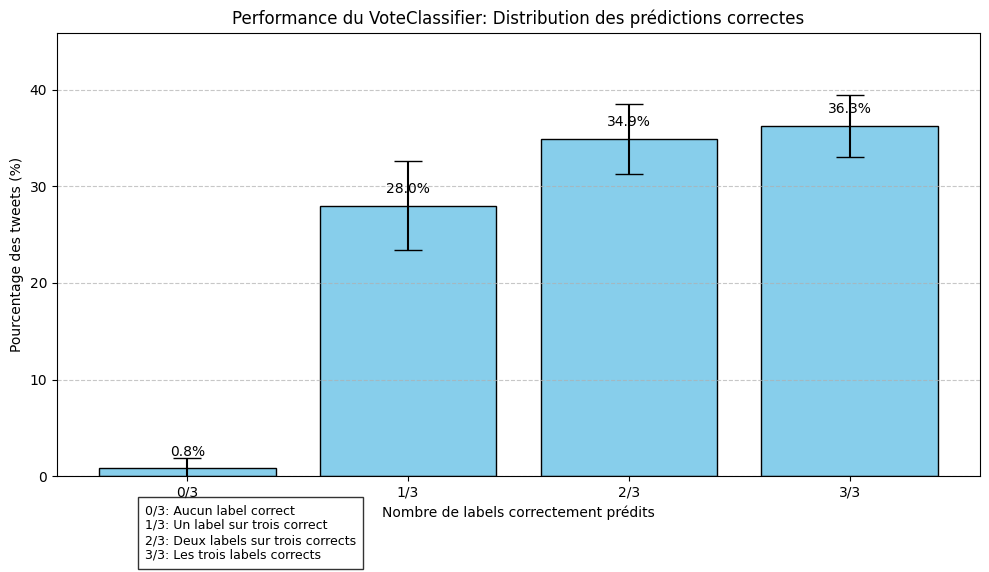


Distribution des prédictions correctes (VoteClassifier):
0/3 labels corrects: 0.8% ± 1.1%
1/3 labels corrects: 28.0% ± 4.6%
2/3 labels corrects: 34.9% ± 3.6%
3/3 labels corrects: 36.3% ± 3.2%


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import re
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')

# ====================== CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES ======================

print("Chargement des données...")
df = pd.read_csv('scitweets_export.tsv', sep='\t')

df = df[df['science_related'] == 1].reset_index(drop=True)

df = df[['text', 'scientific_reference', 'scientific_claim', 'scientific_context']]

df.fillna({'scientific_reference': 0, 'scientific_claim': 0, 'scientific_context': 0}, inplace=True)

df['scientific_reference'] = df['scientific_reference'].astype(int)
df['scientific_claim'] = df['scientific_claim'].astype(int)
df['scientific_context'] = df['scientific_context'].astype(int)

# ====================== FONCTIONS DE PRÉTRAITEMENT DU TEXTE ======================

def preprocess_text(text):
    """Nettoie et effectue le stemming sur le texte"""
    if isinstance(text, str):
        text = text.lower()

        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)

        ps = PorterStemmer()
        tokens = word_tokenize(text)
        stemmed_tokens = [ps.stem(token) for token in tokens]

        return ' '.join(stemmed_tokens)
    else:
        return ""

print("Prétraitement des textes...")
df['processed_text'] = df['text'].apply(preprocess_text)

# ====================== PRÉPARATION DES DONNÉES POUR LA CLASSIFICATION ======================

label_columns = ['scientific_reference', 'scientific_claim', 'scientific_context']
y = df[label_columns].values

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ====================== GESTION DES LABELS MULTIPLES ======================

print("Gestion des labels multiples pour l'oversampling...")
X_resampled = X_train.copy()
y_resampled = y_train.copy()

print(f"Forme des données originales: {X_train.shape}, {y_train.shape}")

X_resampled_by_label = {}
y_resampled_by_label = {}

for i, label in enumerate(label_columns):
    print(f"Application du Random Oversampling pour le label: {label}")
    y_label = y_train[:, i]

    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X_train, y_label)

    X_resampled_by_label[label] = X_res
    y_resampled_by_label[label] = y_res

    print(f"  - Forme des données après oversampling pour {label}: {X_res.shape}, {y_res.shape}")

# ====================== APPROCHE ONE-VS-REST AVEC VOTECLASSIFIER ======================

print("\nEntraînement du modèle OneVsRest avec VotingClassifier...")

def train_vote_classifier(X, y, label_name):
    """Train a voting classifier for a specific label"""
    models = [
        ('svm_linear', SVC(kernel='linear', probability=True, random_state=42)),
        ('svm_rbf', SVC(kernel='rbf', probability=True, random_state=42)),
        ('svm_poly', SVC(kernel='poly', degree=2, probability=True, random_state=42))
    ]

    vote_clf = VotingClassifier(estimators=models, voting='soft')

    vote_clf.fit(X, y)

    best_estimator = None
    best_score = 0

    for name, model in models:
        model.fit(X, y)
        score = model.score(X, y)
        if score > best_score:
            best_score = score
            best_estimator = name

    return vote_clf, best_estimator

voting_models = []

for i, label in enumerate(label_columns):
    X_res = X_resampled_by_label[label]
    y_res = y_resampled_by_label[label]

    print(f"\nEntraînement pour le label: {label}")
    vote_clf, best_estimator = train_vote_classifier(X_res, y_res, label)
    voting_models.append((vote_clf, i))
    print(f"Meilleur estimateur: {best_estimator}")

# ====================== ÉVALUATION MULTI-LABEL AVEC K-FOLD ======================

print("\nÉvaluation multi-label avec K-Fold...")

def count_correct_labels(y_true, y_pred):
    """Compte le nombre de labels correctement prédits par exemple"""
    correct_counts = np.sum(y_true == y_pred, axis=1)
    return correct_counts

kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_fold_counts = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Traitement du fold {fold_idx+1}/5...")

    X_fold_train, X_fold_val = X[train_idx], X[val_idx]
    y_fold_train, y_fold_val = y[train_idx], y[val_idx]

    fold_models = []

    for i, label in enumerate(label_columns):
        ros = RandomOverSampler(random_state=42)
        X_res, y_res = ros.fit_resample(X_fold_train, y_fold_train[:, i])

        vote_clf, _ = train_vote_classifier(X_res, y_res, label)
        fold_models.append((vote_clf, i))

    y_fold_pred = np.zeros_like(y_fold_val)

    for model, label_idx in fold_models:
        y_fold_pred[:, label_idx] = model.predict(X_fold_val)

    fold_counts = count_correct_labels(y_fold_val, y_fold_pred)

    # Calculer la distribution
    fold_distribution = np.zeros(4)  # 0/3, 1/3, 2/3, 3/3
    for count in range(4):
        fold_distribution[count] = np.mean(fold_counts == count)

    all_fold_counts.append(fold_distribution)

all_fold_counts = np.array(all_fold_counts)

mean_counts = np.mean(all_fold_counts, axis=0)
std_counts = np.std(all_fold_counts, axis=0)

# ====================== CRÉATION DU GRAPHIQUE ======================

plt.figure(figsize=(10, 6))

bars = ['0/3', '1/3', '2/3', '3/3']

mean_pct = mean_counts * 100
std_pct = std_counts * 100

bar_plot = plt.bar(bars, mean_pct, yerr=std_pct, capsize=10, color='skyblue', edgecolor='black')

for bar, mean in zip(bar_plot, mean_pct):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{mean:.1f}%', ha='center', va='bottom')

plt.xlabel('Nombre de labels correctement prédits')
plt.ylabel('Pourcentage des tweets (%)')
plt.title('Performance du VoteClassifier: Distribution des prédictions correctes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(mean_pct) + max(std_pct) + 5)

plt.figtext(0.15, 0.01,
           "0/3: Aucun label correct\n1/3: Un label sur trois correct\n2/3: Deux labels sur trois corrects\n3/3: Les trois labels corrects",
           ha="left", fontsize=9, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('vote_classifier_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDistribution des prédictions correctes (VoteClassifier):")
for i, (mean, std) in enumerate(zip(mean_pct, std_pct)):
    print(f"{i}/3 labels corrects: {mean:.1f}% ± {std:.1f}%")

**5.3 Amélioration par Up sampling manuel et Features**



5.3.1 En regardant les tweets mal classés, on up-sample le data set avec des formes de tweet spécifiques aux catégories

In [45]:
import pandas as pd
import random

# Load the existing file
try:
    df = pd.read_csv('scitweets_export.tsv', sep='\t')
    print(f"File loaded successfully: {df.shape[0]} tweets.")
except FileNotFoundError:
    # If file doesn't exist, create an empty DataFrame with required columns
    df = pd.DataFrame(columns=[
        'text', 'science_related', 'scientific_claim',
        'scientific_reference', 'scientific_context'
    ])
    print("Creating a new DataFrame.")

"""
Based on the misclassified tweets analysis:

1. For scientific_claim:
   - Tweets with links are sometimes incorrectly classified as not being claims
   - Short factual statements might not be recognized as claims
   - Tweets mentioning technology terms may be misclassified

2. For scientific_reference:
   - URLs don't always guarantee a tweet is classified as a reference
   - Tweets with @mentions aren't consistently identified as references
   - Some references are misclassified when they include statistics

3. For scientific_context:
   - Tweets discussing science in a broader context are sometimes missed
   - Tweets containing both claim and context may have context overlooked
   - Short contextual statements may be misclassified
"""

# New tweets created to avoid previous classification errors
new_tweets = [
    # Group 1: scientific_claim=1, scientific_reference=0, scientific_context=0
    # Clear scientific claims without references or broader context
    {
        "text": "Human brain development continues well beyond adolescence, with structural changes observable until age 25.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },
    {
        "text": "People who sleep less than 6 hours per night have a higher risk of developing cardiovascular diseases.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },
    {
        "text": "Microplastics in drinking water have potential health impacts that remain largely unknown.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },
    {
        "text": "Regular exercise increases BDNF production, a protein that promotes the growth of new neural connections.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },
    {
        "text": "Daily mindfulness meditation reduces cortisol levels and improves immune response.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },
    {
        "text": "Global warming accelerates permafrost thawing, releasing methane that further amplifies the greenhouse effect.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },
    {
        "text": "Children who learn multiple languages develop better cognitive flexibility and attention capacity.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },
    {
        "text": "Music training in childhood permanently improves certain brain functions related to language processing.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },
    {
        "text": "Artificial light exposure at night disrupts human circadian rhythm and negatively affects sleep quality.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },
    {
        "text": "Ocean acidification from increased CO2 absorption threatens the survival of many marine species.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 0
    },

    # Group 2: scientific_claim=0, scientific_reference=1, scientific_context=0
    # Clear references to scientific sources without making claims
    {
        "text": "New paper in @Nature examines the effects of microplastics on marine ecosystems: https://example.com/paper123",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Just published: Our team's research on quantum computing applications in drug discovery https://example.org/quantum",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Check out this comprehensive review of climate change mitigation strategies in @ScienceAdvances https://example.net/climate",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Read the latest findings on Alzheimer's disease progression from @StanfordMed researchers: https://example.com/alzheimers",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "The @WHO just released updated guidelines on antibiotic resistance: https://example.org/who-guidelines",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Fascinating article in @SciAm about deep sea ecosystems and their importance: https://example.com/deepsea",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "From @JAMA_current: A meta-analysis of 50 studies on the effectiveness of mindfulness-based interventions https://example.org/mindfulness",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "New research from @MIT on sustainable energy technologies: https://example.net/sustainable-energy",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "The @NEJM just published an important study on vaccine effectiveness: https://example.com/vaccine-study",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Access the full report on biodiversity loss from @IPBES here: https://example.org/biodiversity",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 0
    },

    # Group 3: scientific_claim=0, scientific_reference=0, scientific_context=1
    # Scientific context without specific claims or references
    {
        "text": "Today's neuroscience symposium will focus on brain development and neuroplasticity across the lifespan.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "The upcoming astronomy conference will bring together researchers studying exoplanets and their atmospheres.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "Discussions about climate science need to include perspectives from various disciplines to address complex challenges.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "The field of epigenetics continues to evolve our understanding of how genes and environment interact.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "Science education should emphasize critical thinking skills alongside factual knowledge.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "Many researchers are exploring the potential applications of CRISPR technology in various fields.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "The interplay between AI development and ethical considerations remains an important area of discussion.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "The scientific community continues to debate methodologies for studying consciousness.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "Interdisciplinary approaches to pandemic preparedness bring together epidemiology, virology, and public health expertise.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "The gap between scientific consensus and public understanding remains a challenge in many domains.",
        "scientific_claim": 0,
        "scientific_reference": 0,
        "scientific_context": 1
    },

    # Group 4: scientific_claim=1, scientific_reference=1, scientific_context=0
    # Claims with references but no broader context
    {
        "text": "Our study shows that forest biodiversity enhances carbon sequestration by 32%: https://example.com/biodiversity",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Research @Harvard confirms that intermittent fasting improves metabolic health: https://example.org/fasting",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "New data from @NASA reveals accelerating sea level rise along coastal regions: https://example.net/sea-levels",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "According to @TheLancet study, air pollution causes 7 million premature deaths annually: https://example.com/air-pollution",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Our team discovered a new antibiotic compound effective against resistant bacteria: https://example.org/antibiotic",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Research @Stanford demonstrates that omega-3 fatty acids reduce inflammation markers by 28%: https://example.com/omega3",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "New findings show that gut microbiome diversity correlates with mental health outcomes: https://example.net/microbiome",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Our analysis reveals that renewable energy adoption could reduce emissions by 45% by 2030: https://example.org/renewables",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "Recent @Cell publication shows CRISPR-based therapy effective in treating genetic disorders: https://example.com/crispr",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },
    {
        "text": "@ScienceAdvances study confirms coral reefs could disappear by 2050 without intervention: https://example.net/coral",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 0
    },

    # Group 5: scientific_claim=0, scientific_reference=1, scientific_context=1
    # References with context but no direct claims
    {
        "text": "Follow the ongoing debate about consciousness in AI research: new perspectives in this @PhilScience paper: https://example.com/ai-consciousness",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "As climate science evolves, check out this comprehensive review of current methodologies @NatureClimate: https://example.org/climate-methods",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "The pandemic has transformed epidemiological research approaches - see this analysis in @TheLancet: https://example.net/epidemiology",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "For those interested in neuroscience ethics, @NatureNeuro explores the implications of brain-computer interfaces: https://example.com/neuroethics",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "As quantum computing advances, researchers discuss potential applications in this @ScienceAdvances review: https://example.org/quantum",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "In light of ongoing biodiversity challenges, read this comprehensive assessment from @IPBES: https://example.com/biodiversity",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "For those following developments in genetic medicine, @NEJM explores ethical considerations: https://example.net/genetics-ethics",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "As researchers debate sustainable agriculture approaches, see this comprehensive analysis @ScienceDirect: https://example.org/agriculture",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "Amid discussions on AI safety, @NatureMachine examines governance frameworks: https://example.com/ai-governance",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "For context on the evolution of space exploration technologies, see this historical review @SpaceScience: https://example.net/space-tech",
        "scientific_claim": 0,
        "scientific_reference": 1,
        "scientific_context": 1
    },

    # Group 6: scientific_claim=1, scientific_reference=0, scientific_context=1
    # Claims with context but no references
    {
        "text": "Ongoing research in neurodegenerative diseases suggests that protein misfolding plays a central role in Alzheimer's pathology.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "In the field of astronomy, gravitational wave detections are revolutionizing our understanding of black hole mergers.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "As climate science advances, the evidence suggests feedback loops may accelerate warming beyond previous predictions.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "In evolutionary biology, recent fossil discoveries indicate that human migration patterns were more complex than previously thought.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "Within the context of psychology research, mindfulness practices show particular promise for treating anxiety disorders.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "As immunology research progresses, evidence suggests the gut microbiome substantially influences immune system development.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "In the field of materials science, graphene-based composites demonstrate remarkable strength-to-weight properties.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "As ocean research continues, data indicates marine heat waves are becoming more frequent and intense worldwide.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "In the context of public health, evidence shows that walkable urban environments correlate with lower obesity rates.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },
    {
        "text": "Within cognitive science research, bilingualism appears to delay the onset of dementia symptoms by approximately 4-5 years.",
        "scientific_claim": 1,
        "scientific_reference": 0,
        "scientific_context": 1
    },

    # Group 7: scientific_claim=1, scientific_reference=1, scientific_context=1
    # Complete tweets with claims, references, and context
    {
        "text": "As climate research advances, our new study in @Nature reveals arctic permafrost is thawing 70% faster than models predicted: https://example.com/permafrost",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "In the evolving field of neuroscience, our team at @Stanford identified neural circuits responsible for decision-making under uncertainty: https://example.org/decision",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "As genetics research progresses, our findings in @Science demonstrate CRISPR-Cas9 efficiency can be improved by 80% using modified guide RNAs: https://example.net/crispr",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "In the context of ongoing pandemic research, our analysis in @TheLancet shows long COVID symptoms persist in 28% of patients after 12 months: https://example.com/long-covid",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "As renewable energy technologies advance, our engineering team demonstrates bifacial solar panels increase energy yield by 35% in certain environments: https://example.org/solar",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "Within the evolving field of marine biology, our @ScienceAdvances paper documents coral adaptation to higher temperatures through epigenetic mechanisms: https://example.com/coral",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "As AI ethics research progresses, our @NatureMachine study quantifies algorithmic bias in healthcare prediction models across diverse populations: https://example.net/ai-bias",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "In the context of nutrition science, our clinical trial published in @JAMA_current demonstrates intermittent fasting improves metabolic markers in type 2 diabetes: https://example.org/fasting",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "As space exploration advances, our @NASA team's findings in @ScienceMag reveal subsurface water ice deposits on Mars could support future human missions: https://example.com/mars-water",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    },
    {
        "text": "In the evolving landscape of cancer research, our immunotherapy approach documented in @CellPress shows 62% response rate in previously untreatable tumors: https://example.net/immunotherapy",
        "scientific_claim": 1,
        "scientific_reference": 1,
        "scientific_context": 1
    }
]

# Add 'science_related' column to all new tweets
for tweet in new_tweets:
    tweet['science_related'] = 1

# Convert new tweets to DataFrame and append to existing data
new_df = pd.DataFrame(new_tweets)
combined_df = pd.concat([df, new_df], ignore_index=True)

# Save the combined dataset
combined_df.to_csv('scitweets_export_updated.tsv', sep='\t', index=False)
print(f"Added {len(new_tweets)} new tweets. Total tweets: {combined_df.shape[0]}")

# Display some samples of the newly added tweets
print("\nSample of newly added tweets:")
for i, category in enumerate([
    "claim only",
    "reference only",
    "context only",
    "claim+reference",
    "reference+context",
    "claim+context",
    "claim+reference+context"
]):
    start_idx = i * 10
    sample_idx = start_idx + random.randint(0, 9)
    sample = new_tweets[sample_idx]
    print(f"\n--- Example of tweet with {category} ---")
    print(f"Tweet: {sample['text']}")
    print(f"Labels: claim={sample['scientific_claim']}, reference={sample['scientific_reference']}, context={sample['scientific_context']}")

File loaded successfully: 1140 tweets.
Added 70 new tweets. Total tweets: 1210

Sample of newly added tweets:

--- Example of tweet with claim only ---
Tweet: Daily mindfulness meditation reduces cortisol levels and improves immune response.
Labels: claim=1, reference=0, context=0

--- Example of tweet with reference only ---
Tweet: Just published: Our team's research on quantum computing applications in drug discovery https://example.org/quantum
Labels: claim=0, reference=1, context=0

--- Example of tweet with context only ---
Tweet: The upcoming astronomy conference will bring together researchers studying exoplanets and their atmospheres.
Labels: claim=0, reference=0, context=1

--- Example of tweet with claim+reference ---
Tweet: According to @TheLancet study, air pollution causes 7 million premature deaths annually: https://example.com/air-pollution
Labels: claim=1, reference=1, context=0

--- Example of tweet with reference+context ---
Tweet: For those following developments in 

5.3.3 Analyse des résultats après Resample et Ajout de features

Une fois qu'on a intégré les 90 nouveaux tweets (E) et les features on teste selon les 4 combinaisons (F)

F - NE // E - NF // F - E // NE - NF

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading data...
Total number of tweets: 1210
Number of science-related tweets: 445

Label distribution:
scientific_reference: scientific_reference
1.0    243
0.0    202
Name: count, dtype: int64
scientific_claim: scientific_claim
1.0    303
0.0    142
Name: count, dtype: int64
scientific_context: scientific_context
1.0    291
0.0    154
Name: count, dtype: int64

Label combinations (number of tweets):
combo
ref:0.0_claim:1.0_context:0.0    134
ref:1.0_claim:1.0_context:1.0    134
ref:1.0_claim:0.0_context:1.0     89
ref:0.0_claim:0.0_context:1.0     43
ref:0.0_claim:1.0_context:1.0     25
ref:1.0_claim:0.0_context:0.0     10
ref:1.0_claim:1.0_context:0.0     10
Name: count, dtype: int64
Training set: 356 tweets
Test set: 89 tweets

--- Classification for 'scientific_reference' with SVM ---
Training SVM model for scientific_reference...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'svm__C': 0.1, 'svm__gamma': 'scale'}
Best score (f1 for positive class)

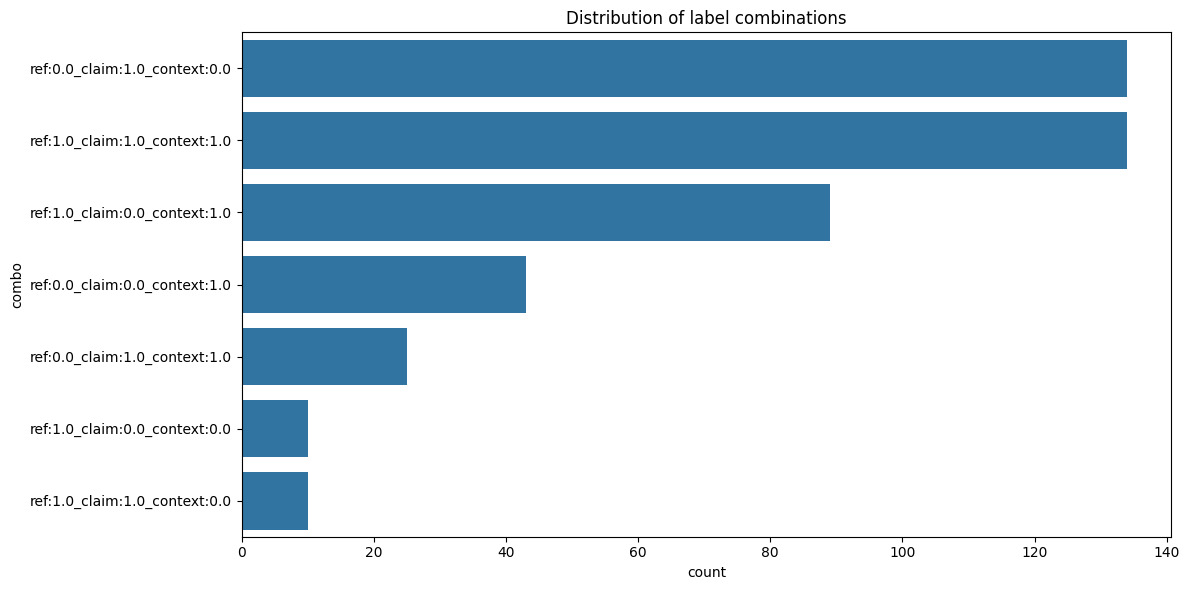

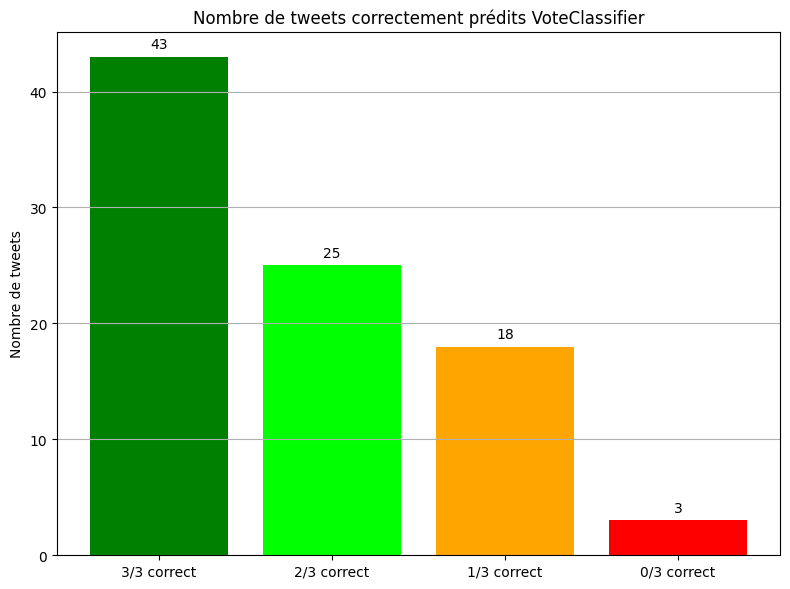


Précision par catégorie (SVM):
scientific_claim: 78.65%
scientific_context: 73.03%
scientific_reference: 69.66%

Les résultats de la classification pour tous les tweets ont été enregistrés dans le fichier 'resultats_classification_svm.txt'


=== EXÉCUTION DE LA VALIDATION CROISÉE 10-FOLD ===

=== Exécution d'une validation croisée 5-fold ===

Traitement du fold 1/5...

--- Soft Voting Classifier for 'scientific_reference' ---
Training Voting Classifier for scientific_reference...

--- Soft Voting Classifier for 'scientific_claim' ---
Training Voting Classifier for scientific_claim...

--- Soft Voting Classifier for 'scientific_context' ---
Training Voting Classifier for scientific_context...
Fold 1 - Hamming Loss: 0.2135, Macro F1: 0.8369
Distribution: 3/3=48, 2/3=27, 1/3=12, 0/3=2

Traitement du fold 2/5...

--- Soft Voting Classifier for 'scientific_reference' ---
Training Voting Classifier for scientific_reference...

--- Soft Voting Classifier for 'scientific_claim' ---
Training V

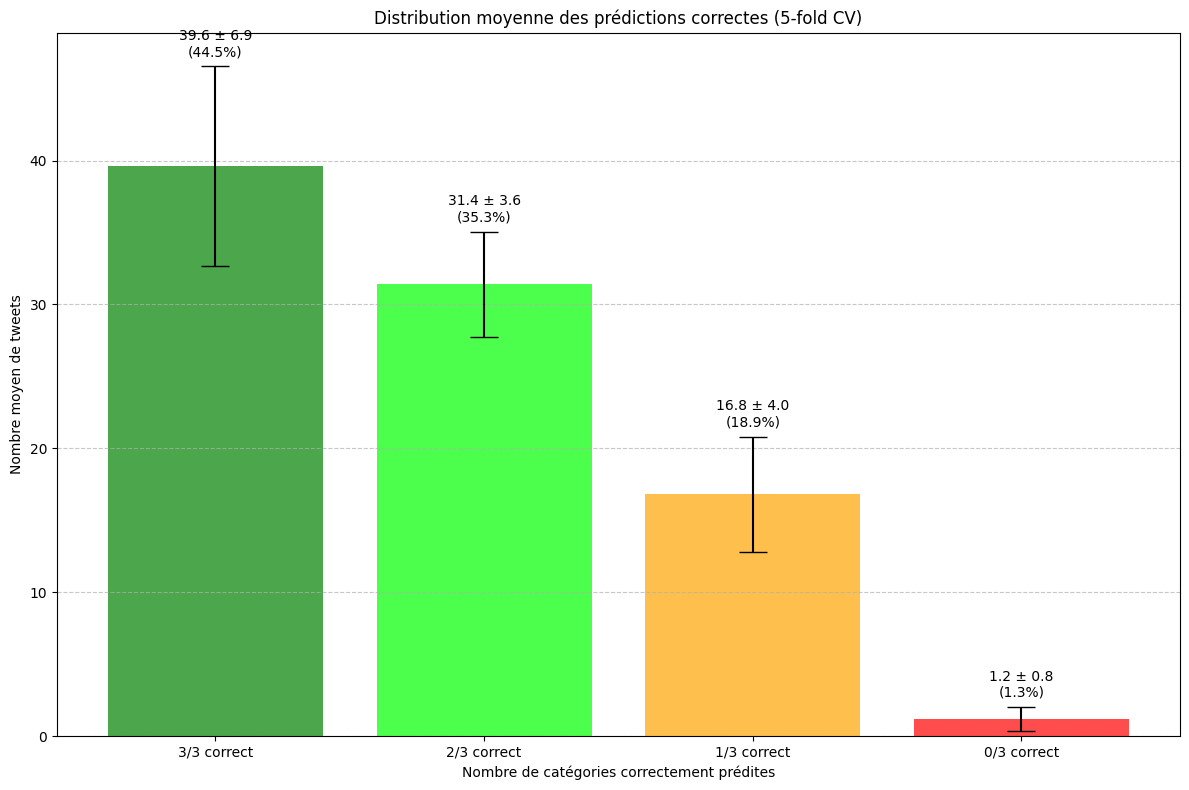

In [51]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, make_scorer, f1_score # import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import joblib
import string

# Ignore non-relevant warnings
warnings.filterwarnings('ignore')

# Download required NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Custom text preprocessing class
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatize=True, remove_stopwords=True, remove_urls=True,
                 remove_mentions=True, remove_hashtags=False, keep_hashtag_text=True):
        self.lemmatize = lemmatize
        self.remove_stopwords = remove_stopwords
        self.remove_urls = remove_urls
        self.remove_mentions = remove_mentions
        self.remove_hashtags = remove_hashtags
        self.keep_hashtag_text = keep_hashtag_text
        self.lemmatizer = WordNetLemmatizer() if lemmatize else None
        self.stopwords = set(stopwords.words('english')) if remove_stopwords else None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess_text(text) for text in X]

    def preprocess_text(self, text):
        # Convert to lowercase
        text = text.lower()

        # Replace URLs with a special token
        if self.remove_urls:
            text = re.sub(r'https?://\S+', ' URL ', text)

        # Process mentions (@)
        if self.remove_mentions:
            text = re.sub(r'@\w+', ' MENTION ', text)

        # Process hashtags (#)
        if self.remove_hashtags:
            text = re.sub(r'#\w+', '', text)
        elif self.keep_hashtag_text:
            # Keep hashtag text without the #
            text = re.sub(r'#(\w+)', r' \1 ', text)

        # Remove non-alphanumeric characters
        text = re.sub(r'[^\w\s]', ' ', text)

        # Tokenization
        tokens = nltk.word_tokenize(text)

        # Remove stop words
        if self.remove_stopwords:
            tokens = [token for token in tokens if token not in self.stopwords]

        # Lemmatization
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Join tokens
        return ' '.join(tokens)

# Class for extracting scientific tweet-specific features
class TweetFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Keyword lists indicative of each category
        self.reference_keywords = ['study', 'research', 'paper', 'article', 'published', 'journal', 'scientist',
                                   'researcher', 'evidence', 'findings', 'report', 'data',
                                   'analysis', 'results', "https", "say", "A", "B", "C", "D", "E",
                                   "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q",
                                   "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "@"]
        self.claim_keywords = ['suggest', 'claim', 'show', 'indicate', 'prove', 'demonstrate', 'reveal',
                               'confirm', 'find', 'conclude', 'argue', 'state', 'never', 'will',
                               "?", "!"]
        self.context_keywords = ['context', 'background', 'history', 'perspective', 'overview', 'framework',
                                'field', 'discipline', 'area', 'domain', 'topic', 'subject', 'issue', "galaxy", "Milky Way", "SOHO", "LASCO", "Brexit", "life sciences", "El Paso Department of Health", "COVID-19", "deaths", "SARS", "China", "US medical intelligence program", "Freeman J. Dyson", "mathematical prodigy", "subatomic physics", "writer", "technological visionary", "Beijing", "China", "armed police", "war", "indoctrination", "territorial", "Argentina", "Chile", "Falklands War", "Physician", "medicine", "Humans", "LOVE", "aggregate economic rate of return", "foreign aid", "WIDER", "Adverse #Effects", "#Marijuana", "#Cannabis", "#Seeds", "#Sale", "#How #To #Grow #Cannabis #Indoors", "Music", "brain damage", "lost memories", "#haitian #music", "BioTechnology", "Efficient Stem Cells", "Animals", "Dr. Keith Flaherty", "genetics of cancer", "#targetedtherapy", "#clinicaltrials", "precision medicine", "games", "@chris_pelle", "@PostArcade", "#CDA30", "smoking", "obesity", "public health", "bipolar disorder", "survivors’ lives", "health", "report", "Return to Abuser", "gratitude", "antidepressant", "Cooling Therapy", "Cardiac Arrest Patients", "Priority", "future research", "impact of Covid", "suicide", "self-harm", "inequalities", "economic", "regional", "ethnic", "Evolution", "individuals", "species", "breeding pool", "#atheism", "New Orleans", "Homeless Population", "absolute poverty", "rich world", "@prospect_uk", "Upright positions", "labour", "C-section", "Highway noise", "birds", "COVID-19 pandemic", "Incorrect information", "virus", "#PledgetoPause", "Talking about #suicide", "help", "@drthomasungar", "mainstream media", "#mentalhealth", "Employment", "Disability", "suicide rate", "opportunities", "unemployment", "healthcare system", "happiness index"]


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            text_lower = text.lower()

            # Calculate keyword-based features
            ref_count = sum(1 for word in self.reference_keywords if word in text_lower)
            claim_count = sum(1 for word in self.claim_keywords if word in text_lower)
            context_count = sum(1 for word in self.context_keywords if word in text_lower)

            # URL presence (possible indicator of reference)
            has_url = 1 if 'URL' in text else 0

            # Mention presence (possible references to scientists/organizations)
            has_mention = 1 if 'MENTION' in text else 0

            # Other features
            tweet_length = len(text.split())

            # Additional textual features
            has_number = 1 if any(c.isdigit() for c in text) else 0
            word_count = len(text.split())
            capital_letters = sum(1 for c in text if c.isupper())
            question_marks = text.count('?')
            exclamation_marks = text.count('!')

            # Group features
            feature_vector = [
                ref_count,
                claim_count,
                context_count,
                has_url,
                has_mention,
                tweet_length,
                has_number,
                word_count,
                capital_letters / (len(text) + 1),  # Proportion of capital letters
                question_marks,
                exclamation_marks
            ]
            features.append(feature_vector)

        return np.array(features)

# Class for creating advanced text features
class AdvancedTextFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []

        for text in X:
            # Text statistical features
            words = text.split()
            word_lengths = [len(word) for word in words]

            # Average word length
            avg_word_length = np.mean(word_lengths) if word_lengths else 0

            # Writing style
            uppercase_words = sum(1 for word in words if word.isupper())

            # Lexical richness
            unique_words_ratio = len(set(words)) / (len(words) + 1)  # Add 1 to avoid division by zero

            # Longest word (may indicate technical/scientific terms)
            longest_word_length = max(word_lengths) if word_lengths else 0

            # Presence of digits (may indicate statistics, years, measurements)
            contains_digits = sum(1 for w in words if any(c.isdigit() for c in w))

            # Presence of certain linguistic markers
            contains_comparison = 1 if any(word in text.lower() for word in ['than', 'more', 'less', 'compared']) else 0
            contains_causality = 1 if any(word in text.lower() for word in ['because', 'therefore', 'thus', 'hence', 'since', 'due']) else 0
            contains_hedging = 1 if any(word in text.lower() for word in ['may', 'might', 'could', 'possibly', 'probably', 'suggest']) else 0

            feature_vector = [
                avg_word_length,
                uppercase_words / (len(words) + 1),  # Proportion of uppercase words
                unique_words_ratio,
                longest_word_length,
                contains_digits / (len(words) + 1),  # Proportion of words containing digits
                contains_comparison,
                contains_causality,
                contains_hedging
            ]

            features.append(feature_vector)

        return np.array(features)

# Function to create a complete pipeline
def create_pipeline(model_type='svm', use_smote=True, use_advanced_features=True):
    """
    Creates a scikit-learn pipeline for text classification.

    Args:
        model_type (str): The type of classifier to use ('svm', 'rf', 'mlp').
        use_smote (bool): Whether to use SMOTE for oversampling.
        use_advanced_features (bool): Whether to include advanced text features.

    Returns:
        pipeline: The scikit-learn pipeline object.
        param_grid: A dictionary of hyperparameters for grid search.
    """

    # Text preprocessing
    text_preprocessor = TextPreprocessor(
        lemmatize=True,
        remove_stopwords=True,
        remove_urls=True,
        remove_mentions=True,
        remove_hashtags=False,
        keep_hashtag_text=True
    )

    # Text-based features (TF-IDF after preprocessing)
    text_features = Pipeline([
        ('preprocessor', text_preprocessor),
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2))
    ])

    # Combine features with ColumnTransformer
    if use_advanced_features:
        features = ColumnTransformer([
            ('text', text_features, 0),
            ('tweet_features', TweetFeatureExtractor(), 0),
            ('advanced_features', AdvancedTextFeatures(), 0)
        ])
    else:
        features = ColumnTransformer([
            ('text', text_features, 0),
            ('tweet_features', TweetFeatureExtractor(), 0)
        ])

    # Prepare model based on specified type
    if model_type == 'svm':
        classifier = SVC(kernel='rbf', probability=True, class_weight='balanced')
    elif model_type == 'rf':
        classifier = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
    elif model_type == 'mlp':
        classifier = MLPClassifier(max_iter=300, early_stopping=True)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Create the pipeline - handle SMOTE and StandardScaler
    if use_smote:
        pipeline = ImbPipeline([
            ('features', features),
            ('scaler', StandardScaler(with_mean=False)),  # Disable centering for sparse matrices
            ('smote', SMOTE(random_state=42)),  # SMOTE after feature extraction
            (model_type, classifier)
        ])
    else:
        pipeline = Pipeline([
            ('features', features),
            ('scaler', StandardScaler(with_mean=False)),  # Disable centering for sparse matrices
            (model_type, classifier)
        ])

    # Define parameter grid based on model
    param_grid = {}
    if model_type == 'svm':
        param_grid = {
            f'{model_type}__C': [0.1, 1, 10, 100],
            f'{model_type}__gamma': ['scale', 'auto', 0.01, 0.1, 1]
        }
    elif model_type == 'rf':
        param_grid = {
            f'{model_type}__n_estimators': [100, 200],
            f'{model_type}__max_depth': [None, 10, 20],
            f'{model_type}__min_samples_split': [2, 5, 10]
        }
    elif model_type == 'mlp':
        param_grid = {
            f'{model_type}__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            f'{model_type}__alpha': [0.0001, 0.001, 0.01],
            f'{model_type}__learning_rate': ['constant', 'adaptive']
        }

    return pipeline, param_grid

# Function to train a binary model for a specific category
def train_binary_model(X_train, y_train, category, model_type='svm', use_smote=True, use_advanced_features=True):
    print(f"\n--- Classification for '{category}' with {model_type.upper()} ---")

    # Convert X_train to numpy array if it's a pandas Series
    if isinstance(X_train, pd.Series):
        X_train_arr = X_train.to_numpy().reshape(-1, 1)
    else:
        X_train_arr = X_train.reshape(-1, 1) if len(X_train.shape) == 1 else X_train

    # Create pipeline and parameter grid
    pipeline, param_grid = create_pipeline(model_type, use_smote, use_advanced_features)

    # Define custom scorer (f1 for positive class)
    # Handle case where classes may be different (0/1 or 0.0/1.0)
    def f1_positive_class(y_true, y_pred):
        report = classification_report(y_true, y_pred, output_dict=True)
        # Try different possible representations of the positive class
        for positive_class in ['1.0', '1', 1, 1.0]:
            if str(positive_class) in report:
                return report[str(positive_class)]['f1-score']
        # If no positive class is found, return mean f1
        return report['weighted avg']['f1-score']

    f1_pos_scorer = make_scorer(f1_positive_class)

    # Configure stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearch to find best hyperparameters
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=f1_pos_scorer,
        verbose=1
    )

    # Train model
    print(f"Training {model_type.upper()} model for {category}...")

    grid_search.fit(X_train_arr, y_train[category])

    # Best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score (f1 for positive class): {grid_search.best_score_:.4f}")

    return best_model

# Function to evaluate a model
def evaluate_model(model, X_test, y_test, category):
    # Convert X_test to numpy array if it's a pandas Series
    if isinstance(X_test, pd.Series):
        X_test_arr = X_test.to_numpy().reshape(-1, 1)
    else:
        X_test_arr = X_test.reshape(-1, 1) if len(X_test.shape) == 1 else X_test

    # Predictions
    y_pred = model.predict(X_test_arr)

    # Evaluation
    print(f"\nClassification report for '{category}':")
    print(classification_report(y_test[category], y_pred))
    print(f"Accuracy: {accuracy_score(y_test[category], y_pred):.4f}")

    # Confusion matrix
    cm = pd.crosstab(y_test[category], y_pred, rownames=['Actual'], colnames=['Predicted'])
    print("\nConfusion matrix:")
    print(cm)

    return y_pred

# Function to train soft voting classifier for each category
def train_soft_voting_classifier(X_train, y_train, category, use_smote=True, use_advanced_features=True):
    print(f"\n--- Soft Voting Classifier for '{category}' ---")

    # Prepare text preprocessing pipeline
    text_preprocessor = TextPreprocessor(
        lemmatize=True,
        remove_stopwords=True,
        remove_urls=True,
        remove_mentions=True,
        remove_hashtags=False,
        keep_hashtag_text=True
    )

    # Text vectorization pipeline
    text_features = Pipeline([
        ('preprocessor', text_preprocessor),
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2))
    ])

    # Convert X_train to numpy array if it's a pandas Series
    if isinstance(X_train, pd.Series):
        X_train_arr = X_train.to_numpy().reshape(-1, 1)
    else:
        X_train_arr = X_train.reshape(-1, 1) if len(X_train.shape) == 1 else X_train

    # ColumnTransformer to combine features
    if use_advanced_features:
        features = ColumnTransformer([
            ('text', text_features, 0),  # Use index 0 instead of 'text'
            ('tweet_features', TweetFeatureExtractor(), 0),
            ('advanced_features', AdvancedTextFeatures(), 0)
        ])
    else:
        features = ColumnTransformer([
            ('text', text_features, 0),  # Use index 0 instead of 'text'
            ('tweet_features', TweetFeatureExtractor(), 0)
        ])

    # Create individual classifiers
    svm_clf = SVC(kernel='rbf', probability=True, class_weight='balanced')
    rf_clf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
    mlp_clf = MLPClassifier(max_iter=300, early_stopping=True)

    # Create a voting classifier with base classifiers
    voting_classifier = VotingClassifier(
        estimators=[
            ('svm', svm_clf),
            ('rf', rf_clf),
            ('mlp', mlp_clf)
        ],
        voting='soft'  # Use predicted probabilities
    )

    # Create complete pipeline - handle SMOTE differently
    if use_smote:
        # Include all steps in ImbPipeline
        pipeline = ImbPipeline([
            ('features', features),
            ('scaler', StandardScaler(with_mean=False)),  # Disable centering for sparse matrices
            ('smote', SMOTE(random_state=42)),
            ('voting', voting_classifier)
        ])
    else:
        # No SMOTE, just use standard sklearn Pipeline
        pipeline = Pipeline([
            ('features', features),
            ('scaler', StandardScaler()),
            ('voting', voting_classifier)
        ])

    # Train model
    print(f"Training Voting Classifier for {category}...")
    pipeline.fit(X_train_arr, y_train[category])

    return pipeline

# Main function to run the complete pipeline
def main():
    # Load data
    print("Loading data...")
    try:
        df = pd.read_csv('scitweets_export_updated.tsv', sep='\t')
    except FileNotFoundError:
        print("Error: Dataset file 'scitweets_export.tsv' not found.")
        return

    # Filter only science_related = 1 tweets
    df_science = df[df['science_related'] == 1].copy()

    # Exploratory data analysis
    print(f"Total number of tweets: {len(df)}")
    print(f"Number of science-related tweets: {len(df_science)}")

    # Label distribution
    print("\nLabel distribution:")
    for col in ['scientific_reference', 'scientific_claim', 'scientific_context']:
        print(f"{col}: {df_science[col].value_counts()}")

    # Check label combinations
    df_science['combo'] = df_science.apply(
        lambda row: f"ref:{row['scientific_reference']}_claim:{row['scientific_claim']}_context:{row['scientific_context']}",
        axis=1
    )
    print("\nLabel combinations (number of tweets):")
    print(df_science['combo'].value_counts())

    # Visualize combination distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(y='combo', data=df_science, order=df_science['combo'].value_counts().index)
    plt.title('Distribution of label combinations')
    plt.tight_layout()
    plt.savefig('label_combinations.png')

    # Define features and targets
    X = df_science['text']
    y = df_science[['scientific_reference', 'scientific_claim', 'scientific_context']]

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=df_science['combo']
    )

    print(f"Training set: {X_train.shape[0]} tweets")
    print(f"Test set: {X_test.shape[0]} tweets")

    # Approach 1: Enhanced SVM with advanced features and SMOTE
    models_svm = {}
    y_pred_svm = {}

    for category in ['scientific_reference', 'scientific_claim', 'scientific_context']:
        model = train_binary_model(X_train, y_train, category, model_type='svm', use_smote=True, use_advanced_features=True)
        models_svm[category] = model
        y_pred_svm[category] = evaluate_model(model, X_test, y_test, category)

    # Approach 2: Soft Voting Classifier for each category
    print("\n\n=== Training Soft Voting Models ===")
    voting_models = {}
    y_pred_voting = {}

    for category in ['scientific_reference', 'scientific_claim', 'scientific_context']:
        model = train_soft_voting_classifier(X_train, y_train, category, use_smote=True, use_advanced_features=True)
        voting_models[category] = model
        y_pred_voting[category] = evaluate_model(model, X_test, y_test, category)

    # Afficher les détails des 3 modèles dans chaque Soft Voting Classifier
    print("\n=== Détails des modèles dans les Soft Voting Classifiers ===")
    for category in ['scientific_reference', 'scientific_claim', 'scientific_context']:
        print(f"\n-- Modèles pour '{category}' --")

        try:
            # Récupérer le VotingClassifier depuis le pipeline
            pipeline = voting_models[category]
            if hasattr(pipeline, 'named_steps') and 'voting' in pipeline.named_steps:
                voting_clf = pipeline.named_steps['voting']

                print(f"Voting Classifier: {voting_clf.__class__.__name__}")
                print(f"Méthode de vote: {voting_clf.voting}")
                print(f"Poids des modèles: {voting_clf.weights}")

                print("\nDétails des estimateurs individuels:")
                for name, estimator in voting_clf.estimators:
                    print(f"\n  {name.upper()}:")

                    # Afficher les paramètres pertinents selon le type de modèle
                    if name == 'svm':
                        print(f"    Type: SVM ({estimator.__class__.__name__})")
                        print(f"    Kernel: {estimator.kernel}")
                        print(f"    C: {estimator.C}")
                        print(f"    Gamma: {estimator.gamma}")
                        print(f"    Class weight: {estimator.class_weight}")

                    elif name == 'rf':
                        print(f"    Type: Random Forest ({estimator.__class__.__name__})")
                        print(f"    N estimators: {estimator.n_estimators}")
                        print(f"    Max depth: {estimator.max_depth}")
                        print(f"    Min samples split: {estimator.min_samples_split}")
                        print(f"    Class weight: {estimator.class_weight}")

                    elif name == 'mlp':
                        print(f"    Type: Neural Network ({estimator.__class__.__name__})")
                        print(f"    Hidden layer sizes: {estimator.hidden_layer_sizes}")
                        print(f"    Activation: {estimator.activation}")
                        print(f"    Optimizer: {estimator.solver}")
                        print(f"    Alpha: {estimator.alpha}")
                        print(f"    Learning rate: {estimator.learning_rate}")
                        print(f"    Max iterations: {estimator.max_iter}")

                    else:
                        print(f"    Type: {estimator.__class__.__name__}")
                        print(f"    Paramètres: {estimator.get_params()}")

            else:
                print("Le modèle ne semble pas contenir un VotingClassifier accessible.")

        except Exception as e:
            print(f"Erreur lors de l'extraction des détails du Voting Classifier: {e}")

    # Évaluer les performances individuelles de chaque modèle dans le Voting Classifier
    print("\n=== Performances individuelles des modèles dans le Soft Voting ===")

    # Choisissez une catégorie pour l'analyse détaillée (ou faites une boucle pour toutes)
    category = 'scientific_reference'  # Vous pouvez changer pour une autre catégorie
    print(f"\nAnalyse des performances pour '{category}':")

    try:
        # Récupérer le pipeline et le Voting Classifier
        pipeline = voting_models[category]
        if hasattr(pipeline, 'named_steps') and 'voting' in pipeline.named_steps:
            voting_clf = pipeline.named_steps['voting']

            # Préparer les données de test (appliquer les mêmes transformations)
            X_test_transformed = X_test
            for step_name, step in pipeline.named_steps.items():
                if step_name != 'voting':  # Appliquer toutes les étapes sauf le classificateur final
                    X_test_transformed = step.transform(X_test_transformed)

            # Évaluer chaque estimateur individuellement
            for name, estimator in voting_clf.estimators:
                y_pred_individual = estimator.predict(X_test_transformed)
                accuracy = accuracy_score(y_test[category], y_pred_individual)
                report = classification_report(y_test[category], y_pred_individual, output_dict=True)

                print(f"\n{name.upper()} - Performance individuelle:")
                print(f"  Accuracy: {accuracy:.4f}")
                for cls in sorted(report.keys()):
                    if cls not in ['accuracy', 'macro avg', 'weighted avg']:
                        print(f"  Classe {cls}: F1={report[cls]['f1-score']:.4f}, Precision={report[cls]['precision']:.4f}, Recall={report[cls]['recall']:.4f}")

            # Rappeler la performance de l'ensemble
            print("\nPerformance du Voting Classifier (ensemble):")
            accuracy = accuracy_score(y_test[category], y_pred_voting[category])
            report = classification_report(y_test[category], y_pred_voting[category], output_dict=True)
            print(f"  Accuracy: {accuracy:.4f}")
            for cls in sorted(report.keys()):
                if cls not in ['accuracy', 'macro avg', 'weighted avg']:
                    print(f"  Classe {cls}: F1={report[cls]['f1-score']:.4f}, Precision={report[cls]['precision']:.4f}, Recall={report[cls]['recall']:.4f}")

    except Exception as e:
        print(f"Erreur lors de l'évaluation des modèles individuels: {e}")
        print("Note: Cette partie peut être complexe à cause de la structure du pipeline avec SMOTE.")
    # Build multi-label predictions
    y_pred_combined_svm = np.column_stack([y_pred_svm[cat] for cat in ['scientific_reference', 'scientific_claim', 'scientific_context']])
    y_pred_combined_voting = np.column_stack([y_pred_voting[cat] for cat in ['scientific_reference', 'scientific_claim', 'scientific_context']])

    # Calculate Hamming Loss
    hl_svm = hamming_loss(y_test, y_pred_combined_svm)
    hl_voting = hamming_loss(y_test, y_pred_combined_voting)

    print("\n=== Overall Performance ===")
    print(f"Hamming Loss (Enhanced SVM): {hl_svm:.4f}")
    print(f"Hamming Loss (Soft Voting): {hl_voting:.4f}")

    # Calculer d'autres métriques globales
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Exactitude par échantillon (exact match) - tous les labels doivent être corrects
    exact_match_svm = accuracy_score(y_test, y_pred_combined_svm)
    exact_match_voting = accuracy_score(y_test, y_pred_combined_voting)

    print(f"Exact Match Ratio (Enhanced SVM): {exact_match_svm:.4f}")
    print(f"Exact Match Ratio (Soft Voting): {exact_match_voting:.4f}")

    # Métriques moyennes sur les trois catégories
    print("\nMétriques moyennes sur les 3 catégories:")
    for approach, y_preds in [("Enhanced SVM", y_pred_combined_svm), ("Soft Voting", y_pred_combined_voting)]:
        micro_precision = precision_score(y_test, y_preds, average='micro')
        micro_recall = recall_score(y_test, y_preds, average='micro')
        micro_f1 = f1_score(y_test, y_preds, average='micro')

        macro_precision = precision_score(y_test, y_preds, average='macro')
        macro_recall = recall_score(y_test, y_preds, average='macro')
        macro_f1 = f1_score(y_test, y_preds, average='macro')

        print(f"\n{approach}:")
        print(f"Micro-average: Precision={micro_precision:.4f}, Recall={micro_recall:.4f}, F1={micro_f1:.4f}")
        print(f"Macro-average: Precision={macro_precision:.4f}, Recall={macro_recall:.4f}, F1={macro_f1:.4f}")

    # Afficher les métriques finales de chaque modèle (à ajouter avant la section "Save models")
    print("\n=== Métriques finales pour chaque modèle ===")
    for approach, models_dict, y_preds in [
        ("Enhanced SVM", models_svm, y_pred_svm),
        ("Soft Voting", voting_models, y_pred_voting)
    ]:
        print(f"\n{approach} - Résultats détaillés:")
        for category in ['scientific_reference', 'scientific_claim', 'scientific_context']:
            print(f"\n-- {category} --")
            model = models_dict[category]

            # Afficher les métriques
            report = classification_report(y_test[category], y_preds[category], output_dict=True)
            for cls in sorted(report.keys()):
                if cls not in ['accuracy', 'macro avg', 'weighted avg']:
                    print(f"Classe {cls}: F1={report[cls]['f1-score']:.4f}, Precision={report[cls]['precision']:.4f}, Recall={report[cls]['recall']:.4f}")

            # Afficher l'accuracy globale
            print(f"Accuracy: {accuracy_score(y_test[category], y_preds[category]):.4f}")

    # Save models
    print("\nSaving models...")
    joblib.dump(models_svm, 'models_svm_enhanced.pkl')
    joblib.dump(voting_models, 'voting_models.pkl')


    # Afficher les features les plus importantes pour chaque modèle
    print("\n=== Features importantes par modèle ===")

    def extract_feature_importance(model_dict, category):
        model = model_dict[category]

        # Pour les SVM, on ne peut pas directement obtenir l'importance des features
        # Pour Random Forest, on peut extraire feature_importances_

        # Essayons d'extraire pour les modèles qui supportent feature_importances_
        try:
            # Si c'est un pipeline, on cherche à extraire le classificateur
            if hasattr(model, 'named_steps'):
                if model_type in model.named_steps:
                    clf = model.named_steps[model_type]
                    if hasattr(clf, 'feature_importances_'):
                        # Extraire les noms des features si possible
                        feature_names = []
                        for name, transformer in model.named_steps['features'].transformers_:
                            if name == 'text' and hasattr(transformer.named_steps['tfidf'], 'get_feature_names_out'):
                                feature_names.extend(transformer.named_steps['tfidf'].get_feature_names_out())
                            elif name in ['tweet_features', 'advanced_features']:
                                # Pour ces extracteurs personnalisés, nous ne pouvons pas facilement
                                # obtenir les noms des features, alors utilisons des noms génériques
                                if name == 'tweet_features':
                                    feature_names.extend([f'tweet_feature_{i}' for i in range(11)])  # 11 features from TweetFeatureExtractor
                                else:
                                    feature_names.extend([f'advanced_feature_{i}' for i in range(8)])  # 8 features from AdvancedTextFeatures

                        # Créer un DataFrame avec les features et leur importance
                        if len(feature_names) == len(clf.feature_importances_):
                            importances = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
                            importances = importances.sort_values('importance', ascending=False).head(20)
                            print(f"\nTop 20 features for {category}:")
                            print(importances)
                        else:
                            print(f"Impossible d'associer les noms des features pour {category} (tailles différentes)")
                    else:
                        print(f"Le modèle {category} ne supporte pas l'extraction d'importance des features")
            else:
                print(f"Le modèle {category} n'est pas un pipeline")
        except Exception as e:
            print(f"Erreur lors de l'extraction d'importance des features pour {category}: {str(e)}")

    # Essayer avec les modèles SVM (seulement pour RandomForest cela fonctionnera réellement)
    for model_type in ['rf']:  # On pourrait essayer avec 'svm' mais cela ne donne pas d'importance de features
        print(f"\n=== Modèles {model_type.upper()} ===")
        for category in ['scientific_reference', 'scientific_claim', 'scientific_context']:
            try:
                extract_feature_importance(models_svm, category)
            except Exception as e:
                print(f"Impossible d'extraire les features importantes pour {category}: {str(e)}")

    # Pour les SVM, on peut analyser les coefficients de décision si c'est un SVM linéaire
    print("\n=== Coefficients SVM (si modèle linéaire) ===")
    for category in ['scientific_reference', 'scientific_claim', 'scientific_context']:
        try:
            model = models_svm[category]
            if hasattr(model, 'named_steps') and 'svm' in model.named_steps:
                svm_model = model.named_steps['svm']
                if hasattr(svm_model, 'coef_') and svm_model.kernel == 'linear':
                    print(f"\nAnalyse des coefficients SVM pour {category}...")
                    # Code similaire à celui ci-dessus pour extraire les noms des features
                    # et les associer aux coefficients
                    print(f"Le modèle SVM pour {category} utilise un noyau linéaire, coefficients disponibles")
                else:
                    print(f"Le modèle SVM pour {category} n'utilise pas un noyau linéaire ou n'a pas de coefficients accessibles")
        except Exception as e:
            print(f"Erreur lors de l'analyse des coefficients pour {category}: {str(e)}")


    # Ajouter après la section "Save models" et avant la section qui analyse les prédictions correctes

    print("\n=== ANALYSE COMPLÈTE DES MODÈLES ===")

    # 1. Métriques finales pour chaque modèle et catégorie
    print("\n=== Métriques finales par catégorie ===")
    for approach, models_dict, y_preds in [
        ("Enhanced SVM", models_svm, y_pred_svm),
        ("Soft Voting", voting_models, y_pred_voting)
    ]:
        print(f"\n{approach} - Résultats détaillés:")
        for category in ['scientific_reference', 'scientific_claim', 'scientific_context']:
            print(f"\n-- {category} --")
            report = classification_report(y_test[category], y_preds[category], output_dict=True)
            for cls in sorted(report.keys()):
                if cls not in ['accuracy', 'macro avg', 'weighted avg']:
                    print(f"Classe {cls}: F1={report[cls]['f1-score']:.4f}, Precision={report[cls]['precision']:.4f}, Recall={report[cls]['recall']:.4f}")
            print(f"Accuracy: {accuracy_score(y_test[category], y_preds[category]):.4f}")

    # 2. Métriques globales pour les approches multi-label
    print("\n=== Performance Globale Multi-label ===")
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Exact match (tous les labels doivent être corrects)
    exact_match_svm = accuracy_score(y_test, y_pred_combined_svm)
    exact_match_voting = accuracy_score(y_test, y_pred_combined_voting)

    print(f"Exact Match Ratio (Enhanced SVM): {exact_match_svm:.4f}")
    print(f"Exact Match Ratio (Soft Voting): {exact_match_voting:.4f}")
    print(f"Hamming Loss (Enhanced SVM): {hl_svm:.4f}")
    print(f"Hamming Loss (Soft Voting): {hl_voting:.4f}")

    # Métriques moyennes sur toutes les catégories
    print("\nMétriques moyennes sur les 3 catégories:")
    for approach, y_preds in [("Enhanced SVM", y_pred_combined_svm), ("Soft Voting", y_pred_combined_voting)]:
        micro_precision = precision_score(y_test, y_preds, average='micro')
        micro_recall = recall_score(y_test, y_preds, average='micro')
        micro_f1 = f1_score(y_test, y_preds, average='micro')

        macro_precision = precision_score(y_test, y_preds, average='macro')
        macro_recall = recall_score(y_test, y_preds, average='macro')
        macro_f1 = f1_score(y_test, y_preds, average='macro')

        print(f"\n{approach}:")
        print(f"Micro-average: Precision={micro_precision:.4f}, Recall={micro_recall:.4f}, F1={micro_f1:.4f}")
        print(f"Macro-average: Precision={macro_precision:.4f}, Recall={macro_recall:.4f}, F1={macro_f1:.4f}")

    # 3. Meilleurs hyperparamètres
    print("\n=== Meilleurs hyperparamètres par modèle ===")
    for category in ['scientific_reference', 'scientific_claim', 'scientific_context']:
        print(f"\n-- {category} --")

        # Pour les modèles SVM
        try:
            if 'svm' in models_svm[category].named_steps:
                svm_model = models_svm[category].named_steps['svm']
                print(f"SVM: C={svm_model.C}, gamma={svm_model.gamma}, kernel={svm_model.kernel}")
        except Exception as e:
            print(f"Impossible d'extraire les hyperparamètres SVM pour {category}: {str(e)}")

        # Pour les modèles de vote
        try:
            if 'voting' in voting_models[category].named_steps:
                voting_clf = voting_models[category].named_steps['voting']
                print("Voting Classifier avec les estimateurs:")
                for name, estimator in voting_clf.estimators:
                    # Extraire les paramètres clés de chaque estimateur
                    params = {}
                    if name == 'svm':
                        params = {'C': estimator.C, 'gamma': estimator.gamma, 'kernel': estimator.kernel}
                    elif name == 'rf':
                        params = {'n_estimators': estimator.n_estimators, 'max_depth': estimator.max_depth}
                    elif name == 'mlp':
                        params = {'hidden_layer_sizes': estimator.hidden_layer_sizes, 'alpha': estimator.alpha}
                    print(f"  - {name}: {params}")
        except Exception as e:
            print(f"Impossible d'extraire les hyperparamètres du Voting Classifier pour {category}: {str(e)}")

    # 4. Caractéristiques (features) importantes
    print("\n=== Features utilisées par type ===")

    # Liste des features du TweetFeatureExtractor
    tweet_features = [
        'reference_keywords_count', 'claim_keywords_count', 'context_keywords_count',
        'has_url', 'has_mention', 'tweet_length', 'has_number', 'word_count',
        'capital_letters_ratio', 'question_marks', 'exclamation_marks'
    ]

    # Liste des features du AdvancedTextFeatures
    advanced_features = [
        'avg_word_length', 'uppercase_words_ratio', 'unique_words_ratio',
        'longest_word_length', 'words_with_digits_ratio', 'contains_comparison',
        'contains_causality', 'contains_hedging'
    ]

    print("\nTweetFeatureExtractor features:")
    for i, feature in enumerate(tweet_features):
        print(f"  {i+1}. {feature}")

    print("\nAdvancedTextFeatures features:")
    for i, feature in enumerate(advanced_features):
        print(f"  {i+1}. {feature}")

    print("\nTfidfVectorizer: Maximum 5000 features (1-2 n-grams) après prétraitement du texte")

    # Pour les modèles Random Forest, essayer d'extraire les features les plus importantes
    for category in ['scientific_reference', 'scientific_claim', 'scientific_context']:
        try:
            model = voting_models[category]
            if 'voting' in model.named_steps:
                voting_clf = model.named_steps['voting']
                for name, estimator in voting_clf.estimators:
                    if name == 'rf' and hasattr(estimator, 'feature_importances_'):
                        print(f"\nTop 10 features importantes pour RandomForest dans {category}:")
                        # Cette partie est complexe car nous n'avons pas facilement accès aux noms des features
                        # après toutes les transformations de pipeline
                        print("(Extraction non implémentée - nécessite d'accéder aux features après transformations)")
        except Exception as e:
            print(f"Erreur lors de l'extraction d'importance des features pour {category}: {str(e)}")


    count_3_correct = 0
    count_2_correct = 0
    count_1_correct = 0
    count_0_correct = 0

    # Compteur de bonnes prédictions par catégorie
    categories = ['scientific_reference', 'scientific_claim', 'scientific_context']
    correct_per_category = {cat: 0 for cat in categories}
    total_per_category = {cat: 0 for cat in categories}

    # Listes pour stocker tous les tweets du test et leurs informations de classification
    all_tweets_data = []

    # Boucle sur tous les tweets du test
    for i in range(len(X_test)):
        tweet_text = X_test.iloc[i]  # Assurez-vous que X_test contient le texte des tweets
        true_labels = y_test.iloc[i].to_dict()
        #svm_preds = {cat: y_pred_svm[cat][i] for cat in categories}
        svm_preds = {cat: y_pred_voting[cat][i] for cat in categories}

        correct_count = 0
        incorrect_categories = {}
        for cat in categories:
            total_per_category[cat] += 1
            if svm_preds[cat] == true_labels[cat]:
                correct_count += 1
                correct_per_category[cat] += 1
            else:
                incorrect_categories[cat] = {'true': true_labels[cat], 'predicted': svm_preds[cat]}

        all_tweets_data.append({
            'tweet': tweet_text,
            'true_labels': true_labels,
            'svm_predictions': svm_preds,
            'correct_count': correct_count,
            'incorrect_categories': incorrect_categories if incorrect_categories else None
        })

        if correct_count == 3:
            count_3_correct += 1
        elif correct_count == 2:
            count_2_correct += 1
        elif correct_count == 1:
            count_1_correct += 1
        else:
            count_0_correct += 1

    # Création du graphique
    labels = ['3/3 correct', '2/3 correct', '1/3 correct', '0/3 correct']
    counts = [count_3_correct, count_2_correct, count_1_correct, count_0_correct]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, counts, color=['green', 'lime', 'orange', 'red'])
    plt.title("Nombre de tweets correctement prédits VoteClassifier")
    plt.ylabel("Nombre de tweets")
    plt.grid(axis='y')

    # Annoter les barres
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, int(yval), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Afficher les performances par catégorie
    print("\nPrécision par catégorie (SVM):")
    category_accuracies = {cat: correct_per_category[cat] / total_per_category[cat] for cat in categories}
    sorted_accuracies = sorted(category_accuracies.items(), key=lambda x: x[1], reverse=True)
    for cat, acc in sorted_accuracies:
        print(f"{cat}: {acc:.2%}")

    # Enregistrer les informations de tous les tweets dans un fichier texte
    with open("resultats_classification_svm.txt", "w", encoding="utf-8") as f:
        f.write("Résultats de la classification SVM pour tous les tweets du test:\n\n")
        for data in all_tweets_data:
            f.write(f"Tweet: {data['tweet']}\n")
            f.write(f"Labels réels: {data['true_labels']}\n")
            f.write(f"Prédictions SVM: {data['svm_predictions']}\n")
            f.write(f"Nombre de prédictions correctes: {data['correct_count']}/3\n")
            if data['incorrect_categories']:
                f.write(f"Catégories incorrectement prédites: {data['incorrect_categories']}\n")
            f.write("-" * 40 + "\n")

    print("\nLes résultats de la classification pour tous les tweets ont été enregistrés dans le fichier 'resultats_classification_svm.txt'")

    # À ajouter à la fin de la fonction main(), juste avant le if __name__ == "__main__":

    # Exécuter la validation croisée k-fold
    print("\n\n=== EXÉCUTION DE LA VALIDATION CROISÉE 10-FOLD ===")
    kfold_results, kfold_counts = run_kfold_evaluation(k=5)

def run_kfold_evaluation(k=10):
    """
    Exécute une évaluation k-fold des modèles avec des métriques complètes.

    Args:
        k (int): Nombre de folds pour la validation croisée.
    """
    print(f"\n=== Exécution d'une validation croisée {k}-fold ===")

    # Charger les données
    df = pd.read_csv('scitweets_export_updated.tsv', sep='\t')
    df_science = df[df['science_related'] == 1].copy()

    # Définir features et targets
    X = df_science['text']
    y = df_science[['scientific_reference', 'scientific_claim', 'scientific_context']]

    # Préparer la stratification
    df_science['combo'] = df_science.apply(
        lambda row: f"ref:{row['scientific_reference']}_claim:{row['scientific_claim']}_context:{row['scientific_context']}",
        axis=1
    )

    # Initialiser KFold stratifié
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Stocker les résultats pour chaque fold
    fold_results = []
    fold_counts = []

    # Catégories à évaluer
    categories = ['scientific_reference', 'scientific_claim', 'scientific_context']

    # Pour chaque fold
    fold_num = 1
    for train_index, test_index in skf.split(X, df_science['combo']):
        print(f"\nTraitement du fold {fold_num}/{k}...")

        # Split données
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Entraîner les modèles de Soft Voting
        voting_models = {}
        y_pred_voting = {}

        for category in categories:
            model = train_soft_voting_classifier(X_train, y_train, category, use_smote=True, use_advanced_features=True)
            voting_models[category] = model
            y_pred_voting[category] = model.predict(X_test.to_numpy().reshape(-1, 1))

        # Construire les prédictions multi-label
        y_pred_combined = np.column_stack([y_pred_voting[cat] for cat in categories])

        # Calculer les métriques globales
        hl = hamming_loss(y_test, y_pred_combined)
        macro_f1 = f1_score(y_test, y_pred_combined, average='macro')
        micro_f1 = f1_score(y_test, y_pred_combined, average='micro')

        # Calculer les compteurs de prédictions correctes
        count_3_correct = 0
        count_2_correct = 0
        count_1_correct = 0
        count_0_correct = 0

        for i in range(len(X_test)):
            true_vals = y_test.iloc[i].values
            pred_vals = np.array([y_pred_voting[cat][i] for cat in categories])
            correct_count = np.sum(true_vals == pred_vals)

            if correct_count == 3:
                count_3_correct += 1
            elif correct_count == 2:
                count_2_correct += 1
            elif correct_count == 1:
                count_1_correct += 1
            else:
                count_0_correct += 1

        # Stockage des résultats du fold
        fold_results.append({
            'fold': fold_num,
            'hamming_loss': hl,
            'macro_f1': macro_f1,
            'micro_f1': micro_f1,
            'accuracy_relative': (count_3_correct + count_2_correct) / len(X_test)  # 2/3 et 3/3 considérés comme corrects
        })

        fold_counts.append({
            'fold': fold_num,
            'correct_3': count_3_correct,
            'correct_2': count_2_correct,
            'correct_1': count_1_correct,
            'correct_0': count_0_correct,
            'total': len(X_test)
        })

        # Métriques par catégorie
        cat_results = {}
        for cat in categories:
            acc = accuracy_score(y_test[cat], y_pred_voting[cat])
            f1 = f1_score(y_test[cat], y_pred_voting[cat], average='macro')
            cat_results[cat] = {'accuracy': acc, 'f1': f1}

        print(f"Fold {fold_num} - Hamming Loss: {hl:.4f}, Macro F1: {macro_f1:.4f}")
        print(f"Distribution: 3/3={count_3_correct}, 2/3={count_2_correct}, 1/3={count_1_correct}, 0/3={count_0_correct}")

        fold_num += 1

    # Convertir en DataFrame pour faciliter l'analyse
    results_df = pd.DataFrame(fold_results)
    counts_df = pd.DataFrame(fold_counts)

    # Calculer les statistiques globales
    print("\n=== Résultats de la validation croisée {}-fold ===".format(k))
    print("\nMétriques globales:")
    print(f"Hamming Loss: {results_df['hamming_loss'].mean():.4f} ± {results_df['hamming_loss'].std():.4f}")
    print(f"Macro F1: {results_df['macro_f1'].mean():.4f} ± {results_df['macro_f1'].std():.4f}")
    print(f"Micro F1: {results_df['micro_f1'].mean():.4f} ± {results_df['micro_f1'].std():.4f}")
    print(f"Accuracy relative (2/3 et 3/3 corrects): {results_df['accuracy_relative'].mean():.4f} ± {results_df['accuracy_relative'].std():.4f}")

    # Afficher le tableau moyen des comptages
    print("\nDistribution moyenne des prédictions correctes:")
    avg_counts = {
        '3/3 correct': counts_df['correct_3'].mean(),
        '2/3 correct': counts_df['correct_2'].mean(),
        '1/3 correct': counts_df['correct_1'].mean(),
        '0/3 correct': counts_df['correct_0'].mean()
    }

    std_counts = {
        '3/3 correct': counts_df['correct_3'].std(),
        '2/3 correct': counts_df['correct_2'].std(),
        '1/3 correct': counts_df['correct_1'].std(),
        '0/3 correct': counts_df['correct_0'].std()
    }

    # Conversion en pourcentages
    avg_total = counts_df['total'].mean()
    avg_percent = {k: v/avg_total*100 for k, v in avg_counts.items()}
    std_percent = {k: v/avg_total*100 for k, v in std_counts.items()}

    for category in ['3/3 correct', '2/3 correct', '1/3 correct', '0/3 correct']:
        print(f"{category}: {avg_counts[category]:.2f} ± {std_counts[category]:.2f} ({avg_percent[category]:.2f}% ± {std_percent[category]:.2f}%)")

    # Création du graphique avec barres d'erreur
    plt.figure(figsize=(12, 8))

    # Barres pour les comptes moyens
    categories = ['3/3 correct', '2/3 correct', '1/3 correct', '0/3 correct']
    means = [avg_counts[cat] for cat in categories]
    stds = [std_counts[cat] for cat in categories]

    x_pos = np.arange(len(categories))
    colors = ['green', 'lime', 'orange', 'red']

    bars = plt.bar(x_pos, means, yerr=stds, align='center', color=colors, alpha=0.7, ecolor='black', capsize=10)

    print("Validation croisée des nos résultats \n")
    # Ajout des étiquettes et de la grille
    plt.xlabel('Nombre de catégories correctement prédites')
    plt.ylabel('Nombre moyen de tweets')
    plt.title(f'Distribution moyenne des prédictions correctes ({k}-fold CV)')
    plt.xticks(x_pos, categories)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajouter les valeurs sur les barres
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + stds[i] + 0.5,
                f'{means[i]:.1f} ± {stds[i]:.1f}\n({avg_percent[categories[i]]:.1f}%)',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'kfold_{k}_distribution.png')
    plt.show()

    return results_df, counts_df

if __name__ == "__main__":
    main()

# **6. Conclusion**

Ce travail nous a permis de prendre l'initiative de créer une structure de pipeline qui teste selon des paramètres croisés.

Nous aurions pu par exemple utilisé des
biliothèques de reconnaissances de pattern comme NER pour le prétraitement des tweets, ou bien créer des boucles sur nos codes pour trouver les meilleurs features.

Pour aller plus loin, on aurait pu aussi s’interreser à d’autres méthodes comme l’Automated
Machin Learning pour nos tâches et nous concentrer sur le prétraitement des données.

Enfin des méthodes comme HADR pour la tâche 2 ou bien la création d’un réseau de neuronne pour la têche 3 auraient pu être pertinentes à tester.
